#**Predictive Equipment Failures**



##Pre-requisites to understand the Business problem :




###What are stripper wells and surface/downhole equipment ?


A stripper well is an oil or gas well that is nearing the end of its economical useful life.(Source : https://en.wikipedia.org/wiki/Stripper_well). Equipments which are on the surface like tubing head,Well head etc are surface equipments.Equipments which are present below the surface like drilling pipes,tubular tools , centralizers etc.




# Background :

80% of producing oil wells in the United States are classified as stripper wells. Stripper wells produce low volumes at the well level, but at an aggregate level these wells are responsible for a significant percentage of domestic oil production.Stripper wells are attractive to a company due to their low operational costs and low capital intensity - ultimately providing a source of steady cash flow to fund operations that require more funds to get off the ground.

# Problem Statement :

Techniques which are built to predict the condition of an in service equipment to make an estimate on when equipment is expected to undergo maintenance to ensure that the loss incurred by the company is less due to the equipment failing.Knowing/Predicting when the equipment is going to fail helps the company to save a lot of time and money on labour in case of a failure.

# Why use Machine Learning to solve this problem ?


 The data given is highly imbalanced and there are many sensor readings which return almost the same value. Given the 107 sensor readings a small error in calculation due to confusion in the numbers can lead to a wrong prediction. The data provided by the company for the actual failure scenarios is very less. We can create synthetic data points(SMOTE) and discard the similar sensor readings to get the required result .



# Whom does this benifit ?





ConocoPhillips is an American multinational energy corporation with its headquarters located in the Energy Corridor district of Houston, Texas in the United States.The Enterprise can use this results obtained from the model to send crews out to a well location to fix equipment on the surface or send a workover rig to the well to pull down-hole equipment and address the failure.

#Mapping the real-world problem to an ML problem :




###Type of Machine Learning Problem:

* There are two different classes which we need to classify,hence it is a binary classification problem.




###Performance Metric:


*   F1 Score



## Why choose F1 Score over other similar metrics ?

*   As a rule of thumb, if the cost of having False negative is high, we want to increase the model sensitivity and recall (In this case predicting that the equipment does not fail but it actually fails.
*   F1 Score gives equal importance to the precision and recall. We do not want the model to predict that the equipment does not fail but actually fails and vice versa. 

*  Where as AUROC compares the  True Positive Rate vs False Positive Rate. So, the bigger the AUROC, the greater the distinction between True Positives and True Negatives
*   When we have a data imbalance between positive and negative samples, we should always use F1-score because ROC averages over all possible thresholds.
In our case we want to increase the Precision and Recall .Hence using F1 score is a more viable option.


###Machine Learing Objectives and Constraints:

####Objective:
 1.  Given the different sensor readings of an equipment, predict wheather the equipment will fail or not
  .





####Constraints:


1. No Latency requirments
2. Minimize the costs associated with failures(Maximize F1 Score)





# Exploratory Data Analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import statsmodels.api as sm
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import scipy.stats as stats
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingClassifier
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
import feature_engine.missing_data_imputers as mdi

## Importing the Data:

In [4]:
Data=pd.read_csv("equip_failures_training_set.csv")
print(Data.shape)

(60000, 172)


## Overview of the Data:

In [ ]:
Data

,id,target,sensor1_measure,sensor2_measure,sensor3_measure,sensor4_measure,sensor5_measure,sensor6_measure,sensor7_histogram_bin0,sensor7_histogram_bin1,sensor7_histogram_bin2,sensor7_histogram_bin3,sensor7_histogram_bin4,sensor7_histogram_bin5,sensor7_histogram_bin6,sensor7_histogram_bin7,sensor7_histogram_bin8,sensor7_histogram_bin9,sensor8_measure,sensor9_measure,sensor10_measure,sensor11_measure,sensor12_measure,sensor13_measure,sensor14_measure,sensor15_measure,sensor16_measure,sensor17_measure,sensor18_measure,sensor19_measure,sensor20_measure,sensor21_measure,sensor22_measure,sensor23_measure,sensor24_histogram_bin0,sensor24_histogram_bin1,sensor24_histogram_bin2,sensor24_histogram_bin3,sensor24_histogram_bin4,sensor24_histogram_bin5,...,sensor77_measure,sensor78_measure,sensor79_measure,sensor80_measure,sensor81_measure,sensor82_measure,sensor83_measure,sensor84_measure,sensor85_measure,sensor86_measure,sensor87_measure,sensor88_measure,sensor89_measure,sensor90_measure,sensor91_measure,sensor92_measure,sensor93_measure,sensor94_measure,sensor95_measure,sensor96_measure,sensor97_measure,sensor98_measure,sensor99_measure,sensor100_measure,sensor101_measure,sensor102_measure,sensor103_measure,sensor104_measure,sensor105_histogram_bin0,sensor105_histogram_bin1,sensor105_histogram_bin2,sensor105_histogram_bin3,sensor105_histogram_bin4,sensor105_histogram_bin5,sensor105_histogram_bin6,sensor105_histogram_bin7,sensor105_histogram_bin8,sensor105_histogram_bin9,sensor106_measure,sensor107_measure
0,1,0,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,2,0,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,...,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,3,0,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,4,0,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,5,0,60874,na,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,59996,0,153002,na,664,186,0,0,0,0,0,2564,59100,1603216,6015982,1968266,164972,12560,4880368,0,280,0,1224,2114,8913782,7998174,1929126,776370,2,0,0,0,3328,1080,0,0,0,0,0,45114,...,0,1872932,4936,1600,0,0,0,0,0,0,0,0,62846,137050,27546,0,0,265640,54496,470800,293652,0,0,0,0,80125300,2912.04,2858,1608808,1479066,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,59997,0,2286,na,2130706538,224,0,0,0,0,0,0,104,99186,36564,128,0,0,56982,0,0,0,0,0,123604,108768,24020,11622,0,0,0,0,192,56,0,0,0,0,0,4610,...,10,

In [ ]:
Data.describe()

,id,target,sensor1_measure,sensor2_measure,sensor3_measure,sensor4_measure,sensor5_measure,sensor6_measure,sensor7_histogram_bin0,sensor7_histogram_bin1,sensor7_histogram_bin2,sensor7_histogram_bin3,sensor7_histogram_bin4,sensor7_histogram_bin5,sensor7_histogram_bin6,sensor7_histogram_bin7,sensor7_histogram_bin8,sensor7_histogram_bin9,sensor8_measure,sensor9_measure,sensor10_measure,sensor11_measure,sensor12_measure,sensor13_measure,sensor14_measure,sensor15_measure,sensor16_measure,sensor17_measure,sensor18_measure,sensor19_measure,sensor20_measure,sensor21_measure,sensor22_measure,sensor23_measure,sensor24_histogram_bin0,sensor24_histogram_bin1,sensor24_histogram_bin2,sensor24_histogram_bin3,sensor24_histogram_bin4,sensor24_histogram_bin5,...,sensor77_measure,sensor78_measure,sensor79_measure,sensor80_measure,sensor81_measure,sensor82_measure,sensor83_measure,sensor84_measure,sensor85_measure,sensor86_measure,sensor87_measure,sensor88_measure,sensor89_measure,sensor90_measure,sensor91_measure,sensor92_measure,sensor93_measure,sensor94_measure,sensor95_measure,sensor96_measure,sensor97_measure,sensor98_measure,sensor99_measure,sensor100_measure,sensor101_measure,sensor102_measure,sensor103_measure,sensor104_measure,sensor105_histogram_bin0,sensor105_histogram_bin1,sensor105_histogram_bin2,sensor105_histogram_bin3,sensor105_histogram_bin4,sensor105_histogram_bin5,sensor105_histogram_bin6,sensor105_histogram_bin7,sensor105_histogram_bin8,sensor105_histogram_bin9,sensor106_measure,sensor107_measure
count,60000.000000,60000.000000,6.000000e+04,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.935500e+04,5.937100e+04,5.937100e+04,5.560000e+04,5.935800e+04,5.937100e+04,5.935800e+04,5.941100e+04,5.935800e+04,5.941100e+04,57277.000000,5.937100e+04,5.937100e+04,5.937100e+04,57500.000000,57499.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,...,46192.000000,4.619200e+04,57497.000000,57276.000000,5.599200e+04,5.599200e+04,5.599200e+04,5.599400e+04,55993.000000,5.599300e+04,5.599200e+04,5.599100e+04,5.930900e+04,5.727600e+04,57274.000000,5.727400e+04,5.727400e+04,5.727300e+04,57273.000000,5.727400e+04,5.727400e+04,5.727700e+04,5.727600e+04,57277.000000,57277.000000,5.599300e+04,49761.000000,50447.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,30000.500000,0.016667,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,4.370966e+05,1.108374e+06,1.657818e+06,4.993098e+05,3.556989e+04,5.114753e+03,1.809931e+06,9.016965e+03,1.143675e+03,9.794900e+02,5.913048e+04,9.328133e+04,3.461037e+06,3.002440e+06,1.004160e+06,4.424045e+05,0.496918,1.267365e+02,5.072046e+03,2.305804e+02,1117.825913,374.327380,1.221165e+04,1.019012e+04,1.097500e+04,7.225784e+03,1.056600e+04,1.119791e+05,...,13.416652,2.200752e+06,3123.961911,375.147112,2.718638e+03,5.609957e+03,4.707073e+03,3.724824e+04,39.938564,1.861313e+03,2.854177e+04,7.923228e+03,3.374545e+04,2.850785e+04,6958.652722,4.529375e+06,2.037598e+05,8.965500e+04,15403.354670,4.058712e+06,5.938350e+05,7.912085e+05,7.780350e+03,0.215759,1.567750,9.717093e+06,1353.131452,1452.155212,7.334042e+05,7.838746e+05,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,17320.652413,0.128020,1.454301e+05,3.478962,7.948749e+08,4.040441e+07,161.543373,209.792592,2.047846e+04,3.420053e+04,1.503220e+05,7.617312e+05,2.374282e+06,3.262607e+06,3.909384e+06,1.422765e+06,2.201524e+05,1.696582e+05,4.185740e+06,1.632778e+05,5.035971e+04,7.583162e+04,5.394658e+05,8.494694e+05,7.790350e+06,6.819518e+06,3.088457e+06,1.262469e+06,5.511653,1.101004e+04,1.196159e+05,1.579952e+04,6598.611557,1482.711621,4

In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 172 entries, id to sensor107_measure
dtypes: int64(3), object(169)
memory usage: 78.7+ MB


## Observation:




1. The difference between mean and median is not insignificant for some features hence we can say that there might be few outliers in the data.
2. There are many NULL values in the Data.
3. Many columns are of the type object which have to be converted into type float 
4. "na" has to be converted to np.NaN for us to perform Analysis on the Dataset






In [5]:
Data=Data.replace('na',np.NaN)
Data=Data.astype(float)

In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 172 entries, id to sensor107_measure
dtypes: float64(172)
memory usage: 78.7 MB


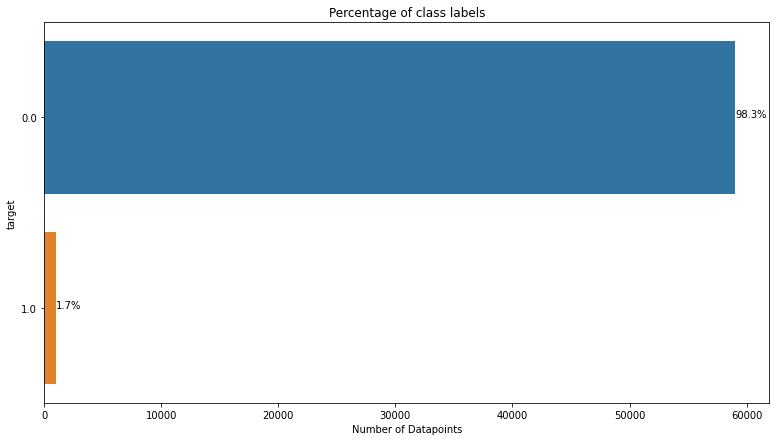

In [ ]:
plt.figure(figsize=(13,7))
ax=sns.countplot(y='target',data=Data)
plt.title('Percentage of class labels')
plt.xlabel('Number of Datapoints')

total = len(Data['target'])
for p in ax.patches:
  percentage = '{:.1f}%'.format(100 * p.get_width()/total)
  x = p.get_x() + p.get_width() + 0.02
  y = p.get_y() + p.get_height()/2
  ax.annotate(percentage, (x, y))

plt.show()

In [ ]:
label_0=0
label_1=0
for i in Data['target']:
  if i==0:
    label_0+=1
  else:
    label_1+=1
print("There are {} labels for the class 0".format(label_0))
print("There are {} labels for the class 1".format(label_1))
    

There are 59000 labels for the class 0
There are 1000 labels for the class 1




1.   The Dataset is highly imbalanced which implies that Accuracy metric cannot be used to decide the performance of the model
2.   Using F1 score would be the best option given the imbalance



## Distribution of NULL values across various features:

In [ ]:
Data.head()

,id,target,sensor1_measure,sensor2_measure,sensor3_measure,sensor4_measure,sensor5_measure,sensor6_measure,sensor7_histogram_bin0,sensor7_histogram_bin1,sensor7_histogram_bin2,sensor7_histogram_bin3,sensor7_histogram_bin4,sensor7_histogram_bin5,sensor7_histogram_bin6,sensor7_histogram_bin7,sensor7_histogram_bin8,sensor7_histogram_bin9,sensor8_measure,sensor9_measure,sensor10_measure,sensor11_measure,sensor12_measure,sensor13_measure,sensor14_measure,sensor15_measure,sensor16_measure,sensor17_measure,sensor18_measure,sensor19_measure,sensor20_measure,sensor21_measure,sensor22_measure,sensor23_measure,sensor24_histogram_bin0,sensor24_histogram_bin1,sensor24_histogram_bin2,sensor24_histogram_bin3,sensor24_histogram_bin4,sensor24_histogram_bin5,...,sensor77_measure,sensor78_measure,sensor79_measure,sensor80_measure,sensor81_measure,sensor82_measure,sensor83_measure,sensor84_measure,sensor85_measure,sensor86_measure,sensor87_measure,sensor88_measure,sensor89_measure,sensor90_measure,sensor91_measure,sensor92_measure,sensor93_measure,sensor94_measure,sensor95_measure,sensor96_measure,sensor97_measure,sensor98_measure,sensor99_measure,sensor100_measure,sensor101_measure,sensor102_measure,sensor103_measure,sensor104_measure,sensor105_histogram_bin0,sensor105_histogram_bin1,sensor105_histogram_bin2,sensor105_histogram_bin3,sensor105_histogram_bin4,sensor105_histogram_bin5,sensor105_histogram_bin6,sensor105_histogram_bin7,sensor105_histogram_bin8,sensor105_histogram_bin9,sensor106_measure,sensor107_measure
0,1.0,0.0,76698.0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,...,18.0,5330690.0,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,2.0,0.0,33058.0,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,...,NaN,NaN,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,3.0,0.0,41040.0,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2341048.0,1494.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13876.0,38182.0,8138.0,0.0,0.0,65772.0,10534.0,300240.0,48028.0,0.0,0.0,0.0,0.0,1040120.0,1018.64,1020.0,262032.0,453378.0,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,4.0,0.0,12.0,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,3232.0,1872.0,0.0,0.0,0.0,2668.0,0.0,0.0,0.0,642.0,3894.0,10184.0,7554.0,10764.0,1014.0,0.0,0.0,0.0,0.0,60.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2578.0,76.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232.0,0.0,0.0,2014.0,370.0,48.0,18.0,15740.0,1822.0,20174.0,44.0,0.0,0.0,0.0,1.08,54.0,5670.0,1566.0,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,5.0,0.0,60874.0,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,1966618.0,1800340.0,131646.0,4588.0,0.0,1974038.0,0.0,226.0,0.0,0.0,0.0,3230626.0,2618878.0,1058136.0,551022.0,0.0,0.0,0.0,0.0,1788.0,642.0,0.0,0.0,0.0,0.0,42124.0,372236.0,...,0.0,3590004.0,2026.0,444.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44946.0,62648.0,11506.0,0.0,0.0,149474.0,35154.0,457040.0,80482.0,98334.0,27588.0,0.0,0.0,21173050.0,1116.06,1176.0,404740.0,904230.0,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [ ]:
for i in Data.columns:
  if i!='id' and i!='target':
    print("The column {} has {} percentage of its values as NULL".format(i,Data[i].isnull().sum() / Data.shape[0] * 100.00))

The column sensor1_measure has 0.0 percentage of its values as NULL
The column sensor2_measure has 77.215 percentage of its values as NULL
The column sensor3_measure has 5.558333333333334 percentage of its values as NULL
The column sensor4_measure has 24.768333333333334 percentage of its values as NULL
The column sensor5_measure has 4.166666666666666 percentage of its values as NULL
The column sensor6_measure has 4.166666666666666 percentage of its values as NULL
The column sensor7_histogram_bin0 has 1.1183333333333334 percentage of its values as NULL
The column sensor7_histogram_bin1 has 1.1183333333333334 percentage of its values as NULL
The column sensor7_histogram_bin2 has 1.1183333333333334 percentage of its values as NULL
The column sensor7_histogram_bin3 has 1.1183333333333334 percentage of its values as NULL
The column sensor7_histogram_bin4 has 1.1183333333333334 percentage of its values as NULL
The column sensor7_histogram_bin5 has 1.1183333333333334 percentage of its values 

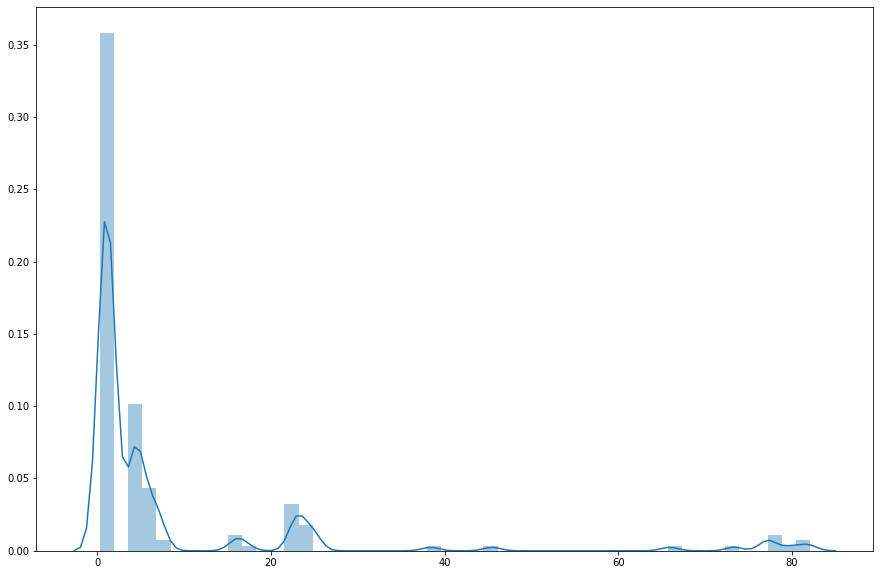

In [ ]:
plt.figure(figsize=(15,10))
x=Data[Data.columns[Data.isnull().any()]].isnull().sum() * 100 / Data.shape[0]
sns.distplot(x,kde=True)

## Observation:




*   For most of the features the percentage of NULL values are in the range of 0 to 20 percentage of their data

*   A very small majority of the features have NULL values in the percentage of 50 to 80 of their own data.
*   These features might be redundant or do not have much information which might contribute towards the training of the model.


*   Those features can be dropped during the data preprocessing stage.



## UNIVARIATE ANALYSIS:

In [ ]:
minimum_value=[]
maximum_value=[]
number_of_zeroes=[]
number_of_null_values=[]
for i in Data.columns:
  if i!='id' and i!='target':
    minimum_value.append(Data[i].min(skipna=True)) #FINDING THE MINIMUM AND MAXIMUM VALUE OF EACH FEATURE
    maximum_value.append(Data[i].max(skipna=True))
    number_of_zeroes.append((Data[i] == 0).sum(axis=0))
    number_of_null_values.append((Data[i].isnull()).sum(axis=0))

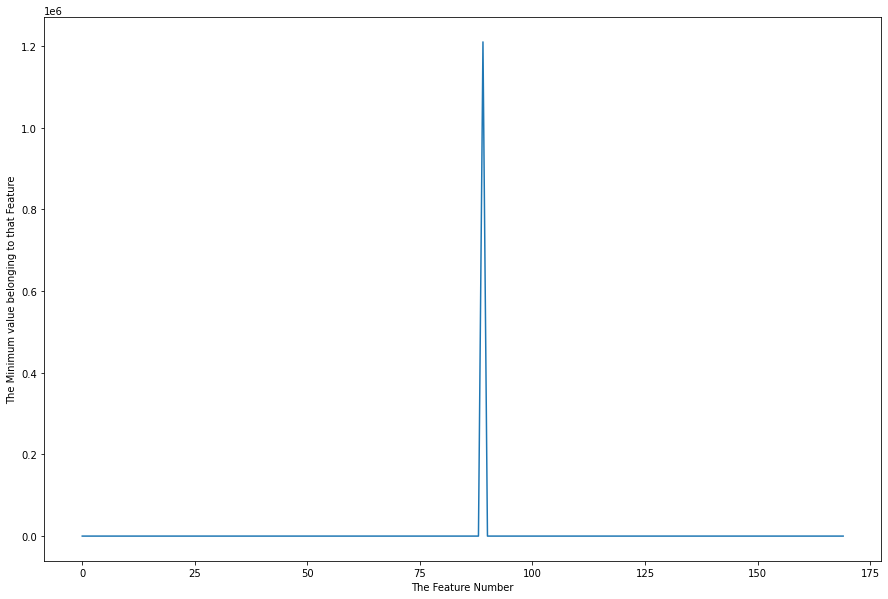

In [ ]:
plt.figure(figsize=(15,10))
plt.xlabel('The Feature Number')
plt.ylabel('The Minimum value belonging to that Feature')
plt.plot(range(0,170),minimum_value)

In [ ]:
for i,j in enumerate(minimum_value):
  if j>0:
    print("The {} feature has a minimum value of {} which is greater than 0".format(Data.columns[i+2],j))


The sensor48_measure feature has a minimum value of 172.0 which is greater than 0
The sensor54_measure feature has a minimum value of 1209600.0 which is greater than 0


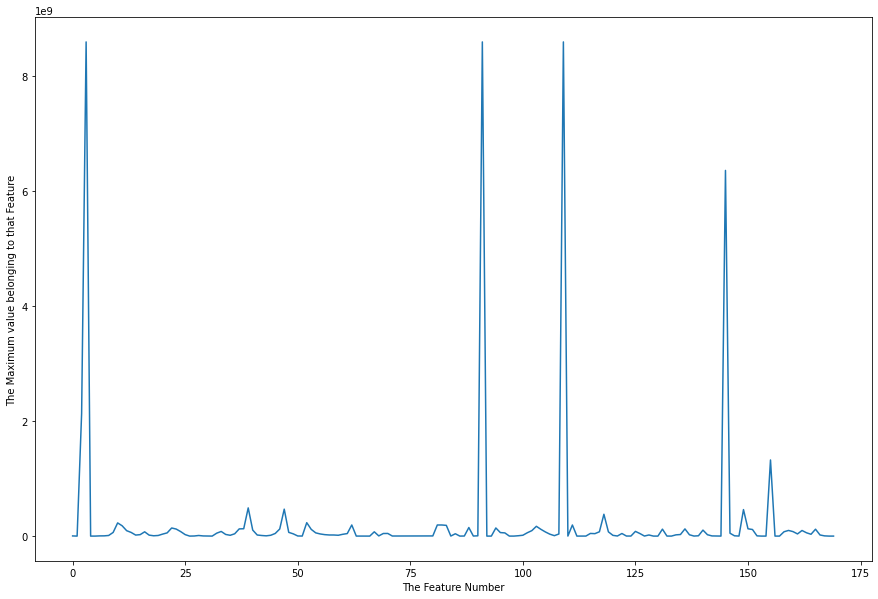

In [ ]:
plt.figure(figsize=(15,10))
plt.xlabel('The Feature Number')
plt.ylabel('The Maximum value belonging to that Feature')
plt.plot(range(0,170),maximum_value)



*   Most of the minimum values are 0
*   Maximum value varies from feature to feature 







###Analysis on the features which have their minimum value greater than 0

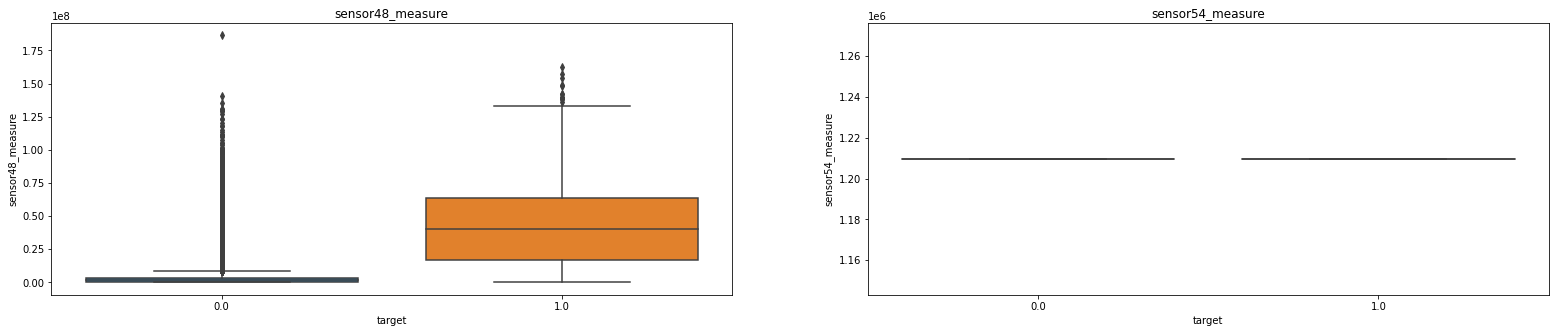

In [ ]:
histograms=['sensor48_measure','sensor54_measure']
fig=plt.figure(figsize=(100,5))
for i,j in enumerate(histograms):
  fig.add_subplot(1,7,i+1)
  ax=sns.boxplot(x=Data['target'],y=Data[j])
  plt.title(j)
plt.show()

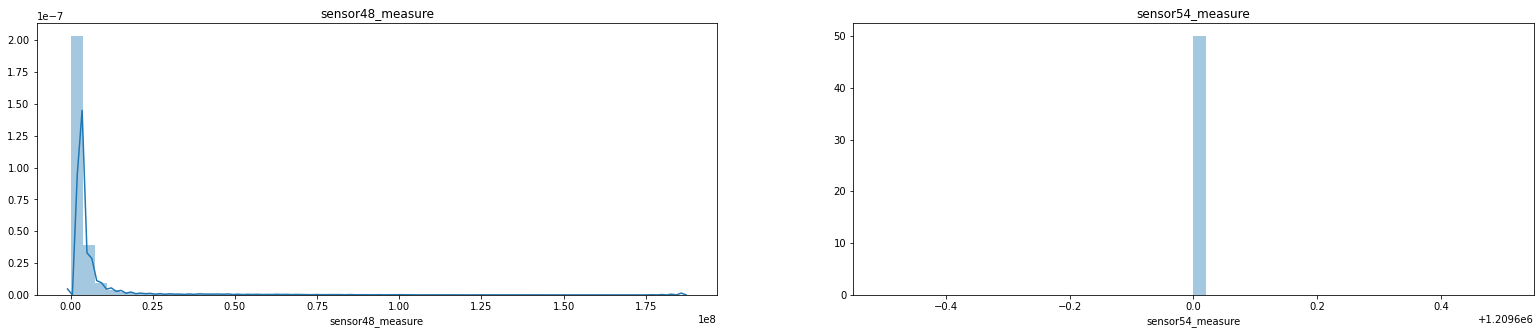

In [ ]:
fig=plt.figure(figsize=(100,5))
for i,j in enumerate(histograms):
  fig.add_subplot(1,7,i+1)
  ax=sns.distplot(Data[j],kde=True)
  plt.title(j)
plt.show()

In [ ]:
print("The number of unique Data points in sensor54_measure are ",len(Data['sensor54_measure'].unique()))
print("The number of unique Data points in sensor48_measure are ",len(Data['sensor48_measure'].unique()))

The number of unique Data points in sensor54_measure are  2
The number of unique Data points in sensor48_measure are  52849


In [ ]:
print("Maximum value of sensor54_measure is ",np.max(Data['sensor54_measure']))
print("Minimum value of sensor54_measure is ",np.min(Data['sensor54_measure']))
print("The unique values of sensor54_measure are ",Data['sensor54_measure'].unique())

Maximum value of sensor54_measure is  1209600.0
Minimum value of sensor54_measure is  1209600.0
The unique values of sensor54_measure are  [1209600.      nan]


###Observations:

*   Sensor48_measure is able to classify the data points well for the minority class which is class 1 with very few outliers but doesnt do a good job for class 0. It is right skewed.
*   Sensor54_measure isnt able to distinguish between class 0 and 1  for any of its datapoints. After checking through its maximum and minimum value we can observe that there are only two unique values in that feature i.e 12609600 and Nan 

* We can conclude that sensor54_measure does not give an valuable information as it is same for all the datapoints and the remaining values are null.
* Hence Sensor54_measure can be discarded.





## Analysis of features with a maximum value beyond a given threshold

In [ ]:
print(sorted(maximum_value)[::-1][0:30])

[8584297742.0, 8584297742.0, 8584297736.0, 6351872864.0, 2130706796.0, 1322456920.0, 489678156.0, 467832334.0, 460207620.0, 379142116.0, 232871714.0, 228830570.0, 192871534.0, 192871534.0, 192871534.0, 192871534.0, 186353854.0, 179187978.0, 169869316.0, 148615188.0, 140986129.9, 140861830.0, 127680326.0, 127034534.0, 124948914.0, 124700880.0, 123047106.0, 122201822.0, 120759484.0, 119580108.0]


In [ ]:
max_check=[]
for i,j in enumerate(maximum_value):
  if j>=186353854.0: ##checking features with a maximum value greater than 186353854 by randomly setting a threshold which is not too small 
    print("The {} feature has a maximum value of {}".format(Data.columns[i+2],j))
    max_check.append(Data.columns[i+2])

The sensor3_measure feature has a maximum value of 2130706796.0
The sensor4_measure feature has a maximum value of 8584297742.0
The sensor7_histogram_bin4 feature has a maximum value of 228830570.0
The sensor24_histogram_bin7 feature has a maximum value of 489678156.0
The sensor25_histogram_bin5 feature has a maximum value of 467832334.0
The sensor26_histogram_bin0 feature has a maximum value of 232871714.0
The sensor27_measure feature has a maximum value of 192871534.0
The sensor46_measure feature has a maximum value of 192871534.0
The sensor47_measure feature has a maximum value of 192871534.0
The sensor48_measure feature has a maximum value of 186353854.0
The sensor56_measure feature has a maximum value of 8584297736.0
The sensor65_measure feature has a maximum value of 8584297742.0
The sensor67_measure feature has a maximum value of 192871534.0
The sensor69_histogram_bin5 feature has a maximum value of 379142116.0
The sensor92_measure feature has a maximum value of 6351872864.0
The

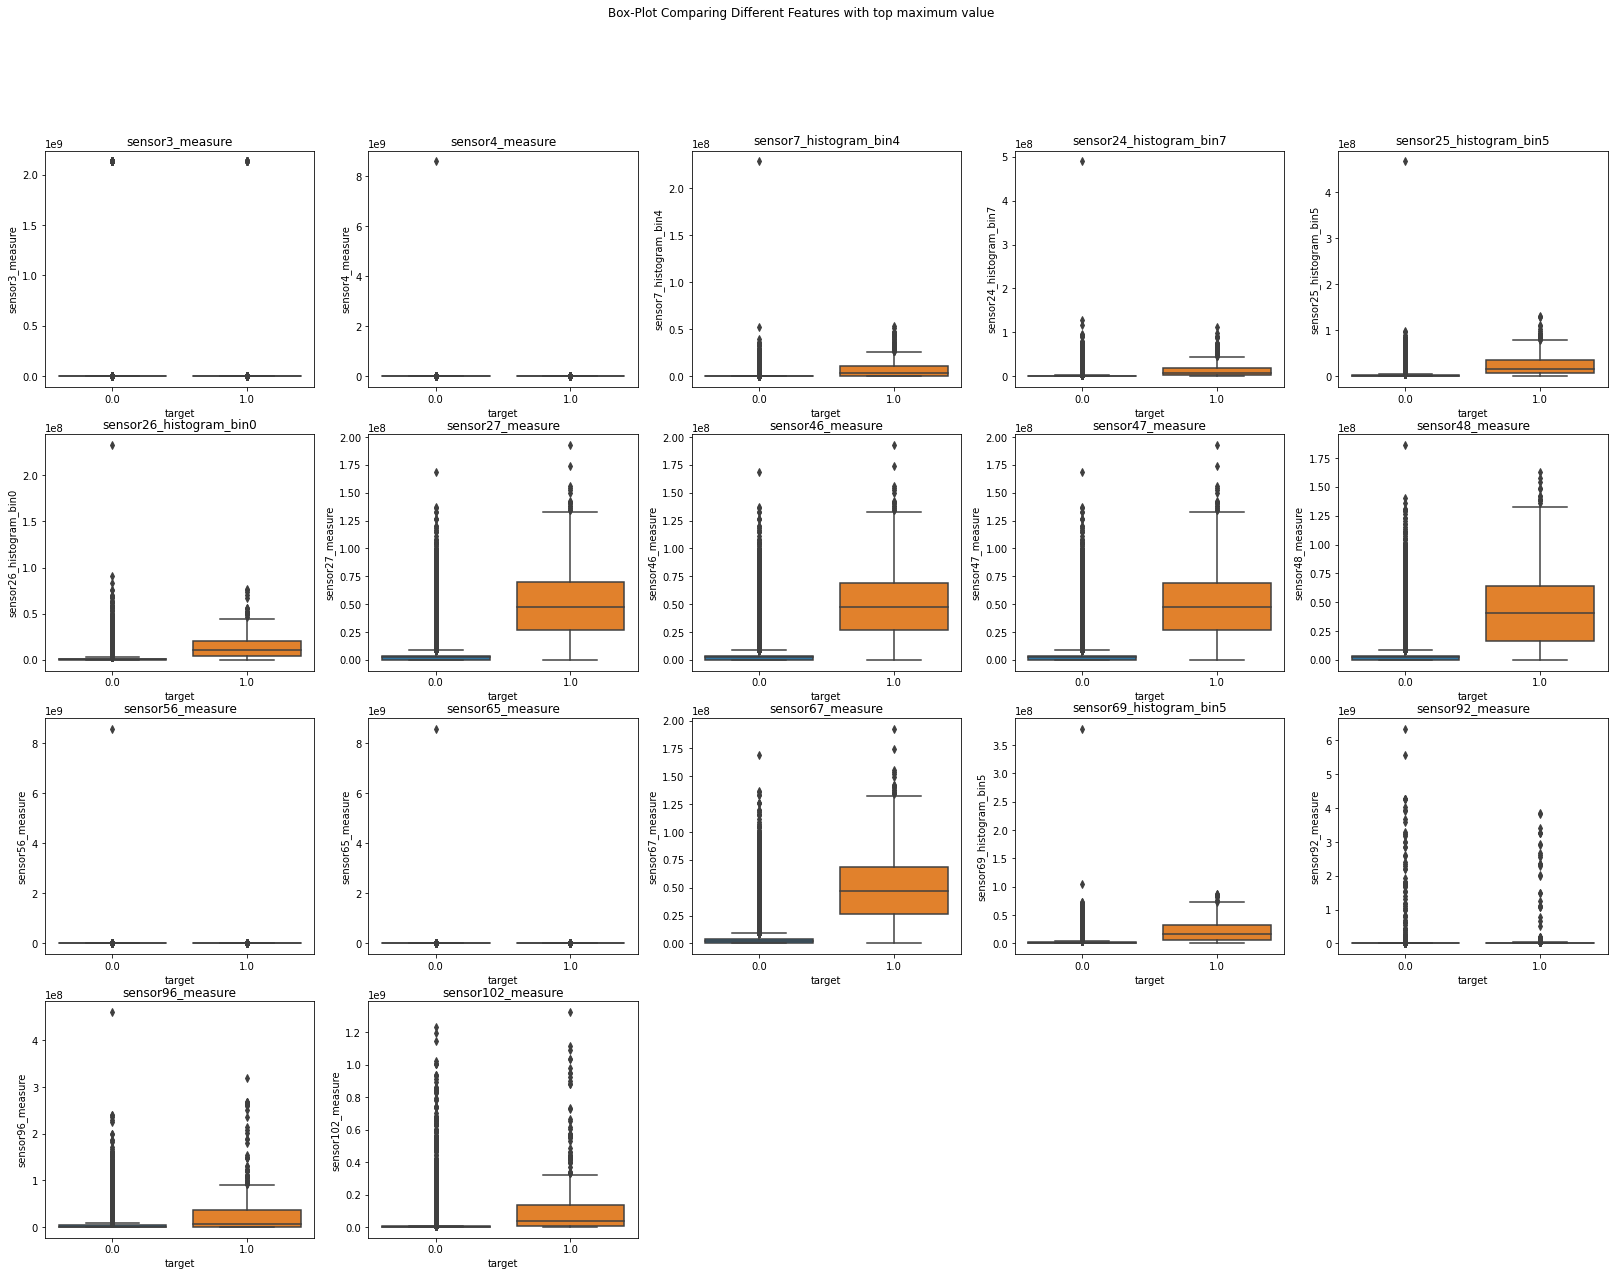

In [ ]:
fig=plt.figure(figsize=(28,20))
for i,j in enumerate(max_check):
  fig.add_subplot(4,5,i+1)
  ax=sns.boxplot(x=Data['target'],y=Data[j])
  plt.title(j)
plt.suptitle("Box-Plot Comparing Different Features with top maximum value")
plt.show()

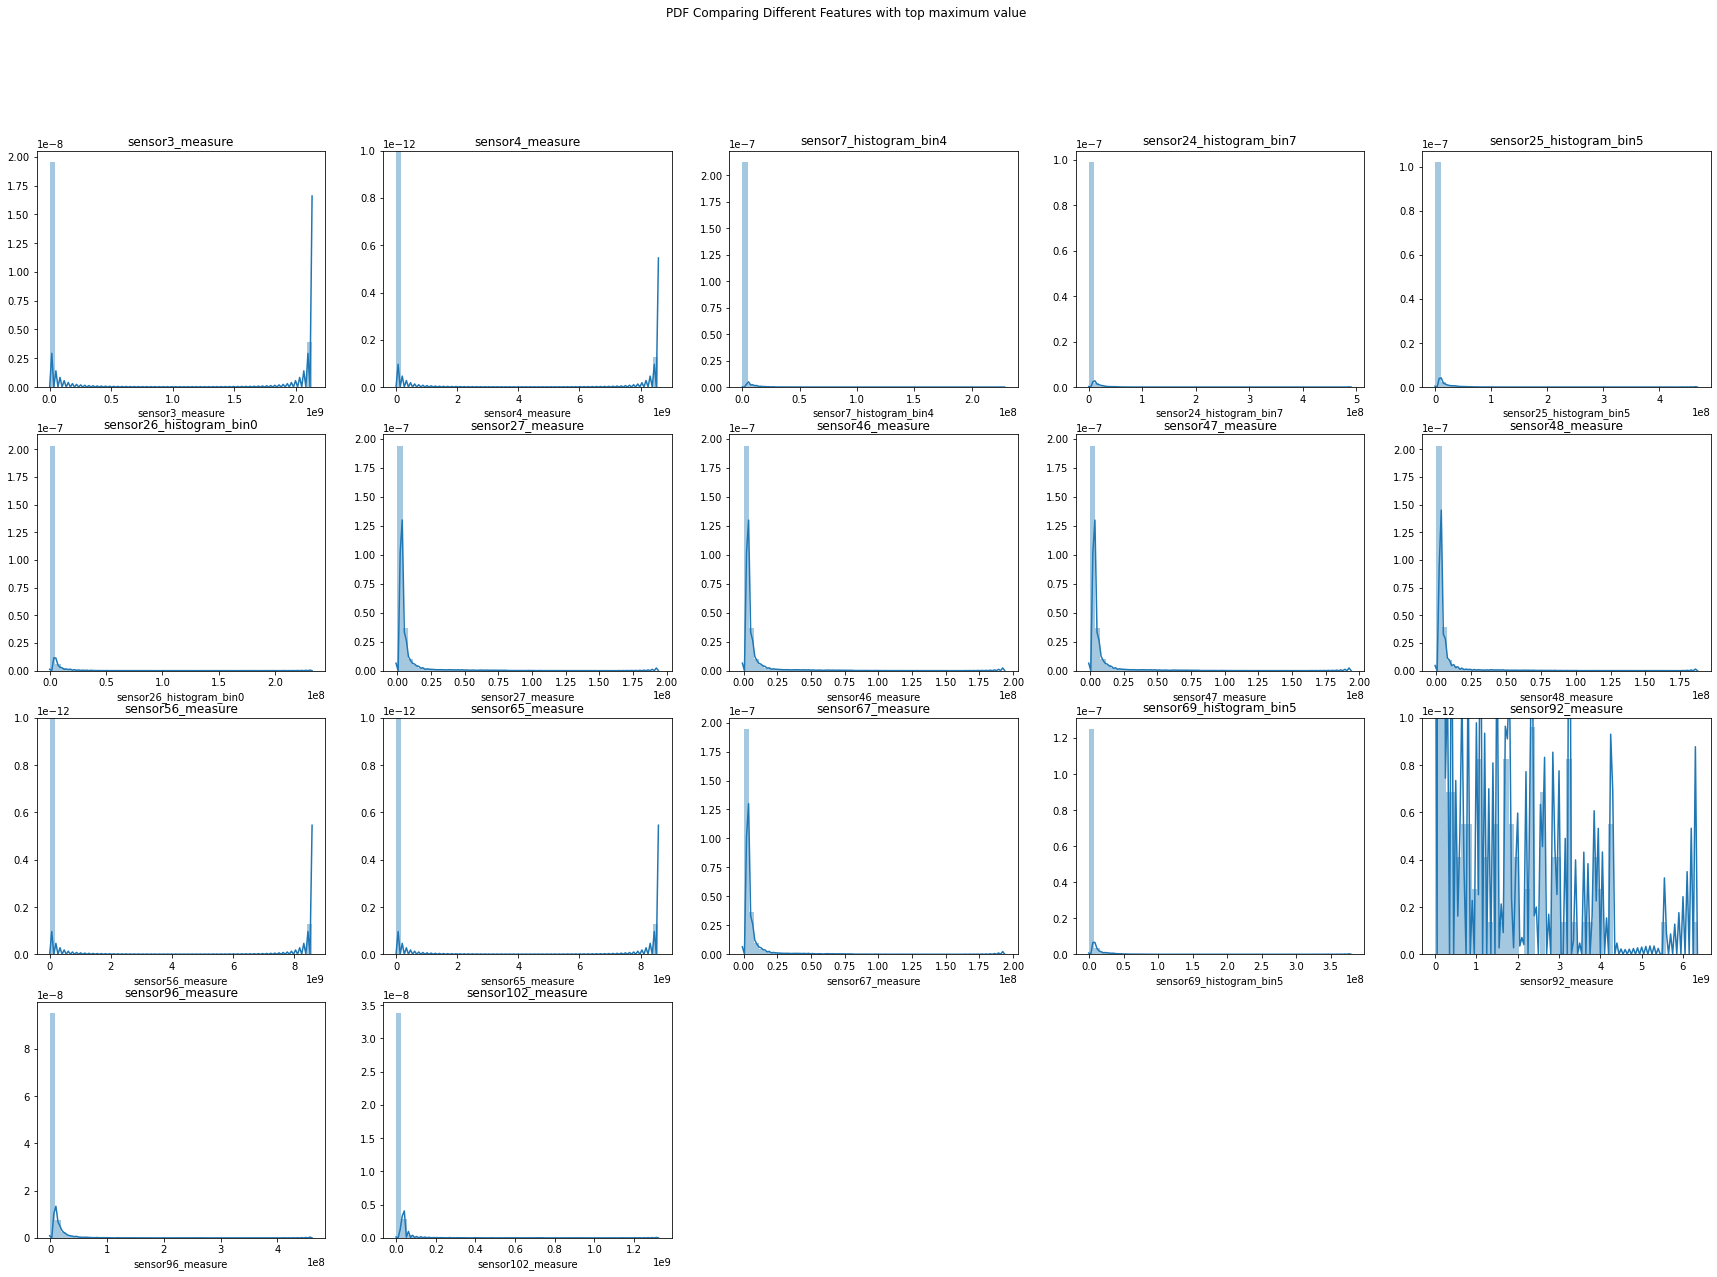

In [ ]:
fig=plt.figure(figsize=(30,20))
for i,j in enumerate(max_check):
  fig.add_subplot(4,5,i+1)
  ax=sns.distplot(Data[j],kde=True)
  plt.title(j)
  if i==16:
    break
plt.suptitle("PDF Comparing Different Features with top maximum value")
plt.show()

In [ ]:
Data['sensor92_measure'].describe()

count    5.727400e+04
mean     4.529375e+06
std      9.748478e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.351873e+09
Name: sensor92_measure, dtype: float64

### Observations:

*  The features with highest maximum values for the given threshold are able to classify most of the datapoints well for class 1 with minimal outliers but do not do the same for class 0
* Most of the features which are present are in the form of sensor(n) and sensor(n+1) . Example - Sensor47_measure and sensor48_measure are having maximum value beyond the given threshold
* This might imply that the these sensors might be placed at the same place or nearby each other hence the readings are similar. Hence they might be correlated features. 
* Most of the features are right skewed except for sensor92_measure

* The feature sensor92_measure has a lot of variability among its datapoints . The mean and median vary alot which might mean that the feature might be affected my outliers 





## Counting number of NULL and Zero values per feature

<BarContainer object of 170 artists>

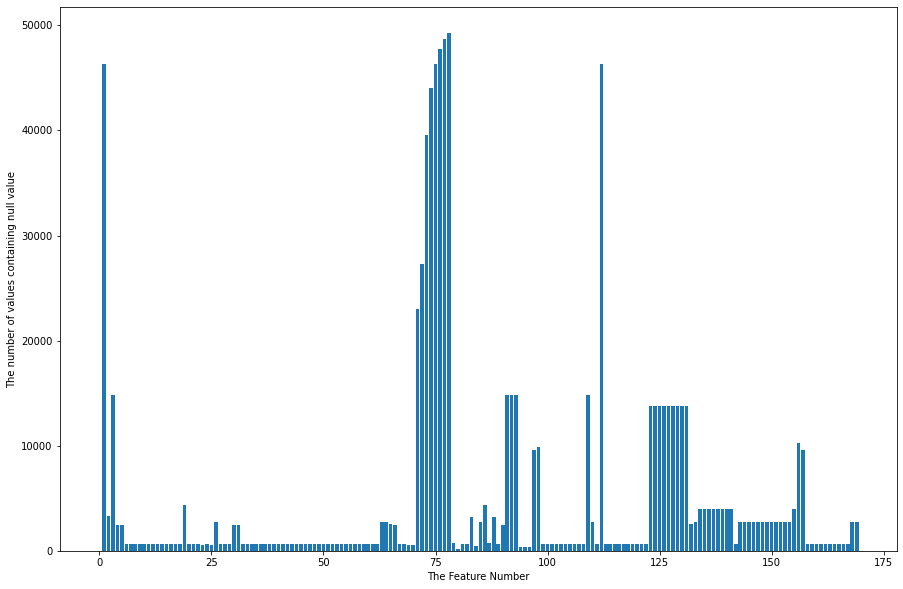

In [ ]:
plt.figure(figsize=(15,10))
plt.xlabel('The Feature Number')
plt.ylabel('The number of values containing null value')
plt.bar(range(0,170),number_of_null_values)

In [ ]:
max_null=[]
for i,j in enumerate(number_of_null_values):
    print("The {} feature has  {} of null values ".format(Data.columns[i+2],j))
    max_null.append(Data.columns[i+2])

The sensor1_measure feature has  0 of null values 
The sensor2_measure feature has  46329 of null values 
The sensor3_measure feature has  3335 of null values 
The sensor4_measure feature has  14861 of null values 
The sensor5_measure feature has  2500 of null values 
The sensor6_measure feature has  2500 of null values 
The sensor7_histogram_bin0 feature has  671 of null values 
The sensor7_histogram_bin1 feature has  671 of null values 
The sensor7_histogram_bin2 feature has  671 of null values 
The sensor7_histogram_bin3 feature has  671 of null values 
The sensor7_histogram_bin4 feature has  671 of null values 
The sensor7_histogram_bin5 feature has  671 of null values 
The sensor7_histogram_bin6 feature has  671 of null values 
The sensor7_histogram_bin7 feature has  671 of null values 
The sensor7_histogram_bin8 feature has  671 of null values 
The sensor7_histogram_bin9 feature has  671 of null values 
The sensor8_measure feature has  645 of null values 
The sensor9_measure feat

<BarContainer object of 170 artists>

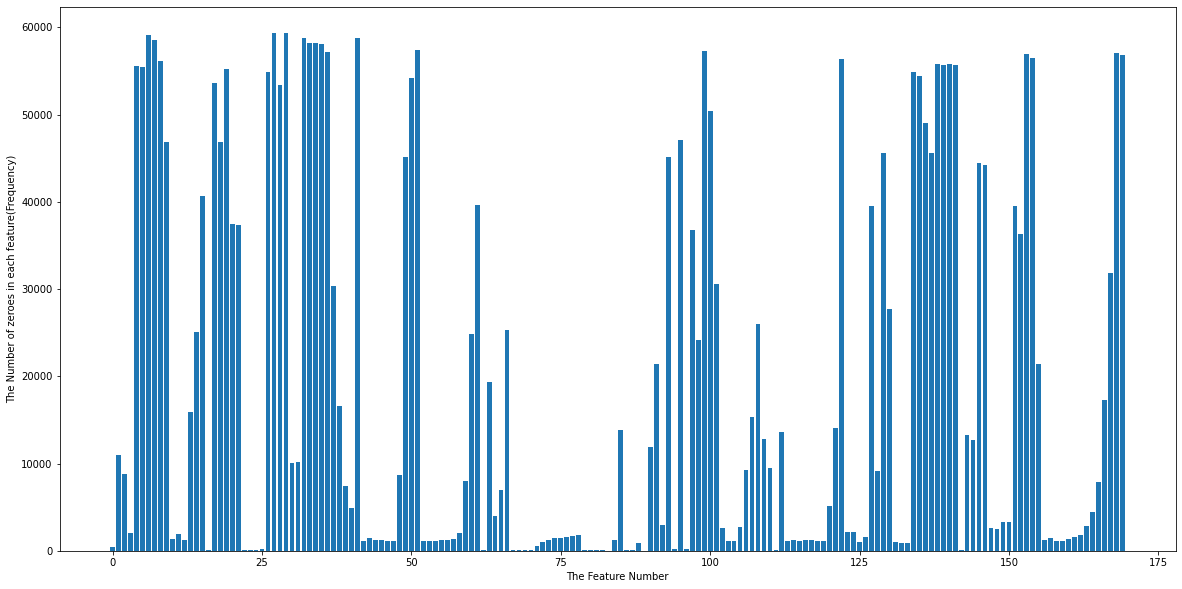

In [ ]:
plt.figure(figsize=(20,10))
plt.xlabel('The Feature Number')
plt.ylabel('The Number of zeroes in each feature(Frequency)')
plt.bar(range(0,170),number_of_zeroes)

In [ ]:
least_zeroes=[]
for i,j in enumerate(number_of_zeroes):
    print("The {} feature has  {} of zeroe values ".format(Data.columns[i+2],j))
    least_zeroes.append(Data.columns[i+2])

The sensor1_measure feature has  393 of zeroe values 
The sensor2_measure feature has  10977 of zeroe values 
The sensor3_measure feature has  8752 of zeroe values 
The sensor4_measure feature has  2009 of zeroe values 
The sensor5_measure feature has  55543 of zeroe values 
The sensor6_measure feature has  55476 of zeroe values 
The sensor7_histogram_bin0 feature has  59133 of zeroe values 
The sensor7_histogram_bin1 feature has  58587 of zeroe values 
The sensor7_histogram_bin2 feature has  56181 of zeroe values 
The sensor7_histogram_bin3 feature has  46894 of zeroe values 
The sensor7_histogram_bin4 feature has  1305 of zeroe values 
The sensor7_histogram_bin5 feature has  1941 of zeroe values 
The sensor7_histogram_bin6 feature has  1238 of zeroe values 
The sensor7_histogram_bin7 feature has  15875 of zeroe values 
The sensor7_histogram_bin8 feature has  25091 of zeroe values 
The sensor7_histogram_bin9 feature has  40698 of zeroe values 
The sensor8_measure feature has  133 of z



*   Many features have significant number of 0's
*   These 0's might mean that there are no notable phenomenon happening around that sensor








## Checking Random Histogram bin features and PDF based on the different percentage of NULL values present in them:

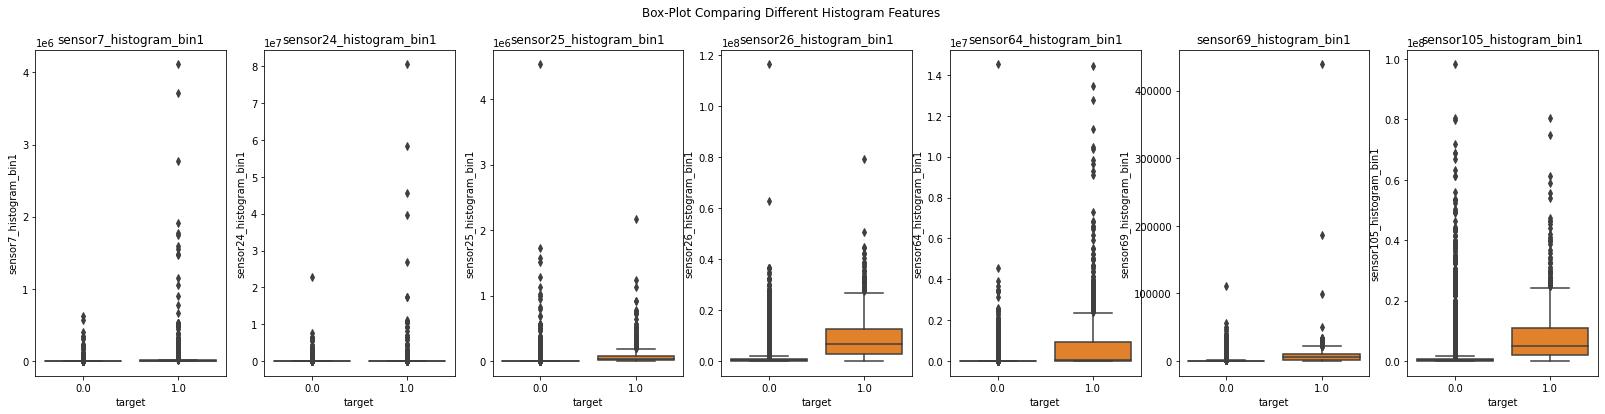

In [ ]:
histograms=['sensor7_histogram_bin1','sensor24_histogram_bin1','sensor25_histogram_bin1','sensor26_histogram_bin1','sensor64_histogram_bin1','sensor69_histogram_bin1','sensor105_histogram_bin1']
fig=plt.figure(figsize=(28,6))
for i,j in enumerate(histograms):
  fig.add_subplot(1,7,i+1)
  ax=sns.boxplot(x=Data['target'],y=Data[j])
  plt.title(j)
plt.suptitle("Box-Plot Comparing Different Histogram Features")
plt.show()



*  Rather than taking all the histogram features and plotting the box-plot I have taken different features based on the number of Nan values present in them.

*   sensor7_histogram_bin1 isn't interpretable
*   sensor24_histogram_bin1 isn't interpretable
*   sensor25_histogram_bin1 isn't interpretable

*   sensor26_histogram_bin1,is able to classify class 1 and is able to distinguish the IQR for it. But the class 0 is not interpretable
*   sensor64_histogram_bin1,is able to classify class 1 but not able to distinguish between the percentiles below 50. It classifies most of the class 1's points as outliers.


*   sensor69_histogram_bin1 isn't interpretable
*   sensor105_histogram_bin1 classifies the points fairly well for class 1 but classifies most of the points as outliers for class 0.









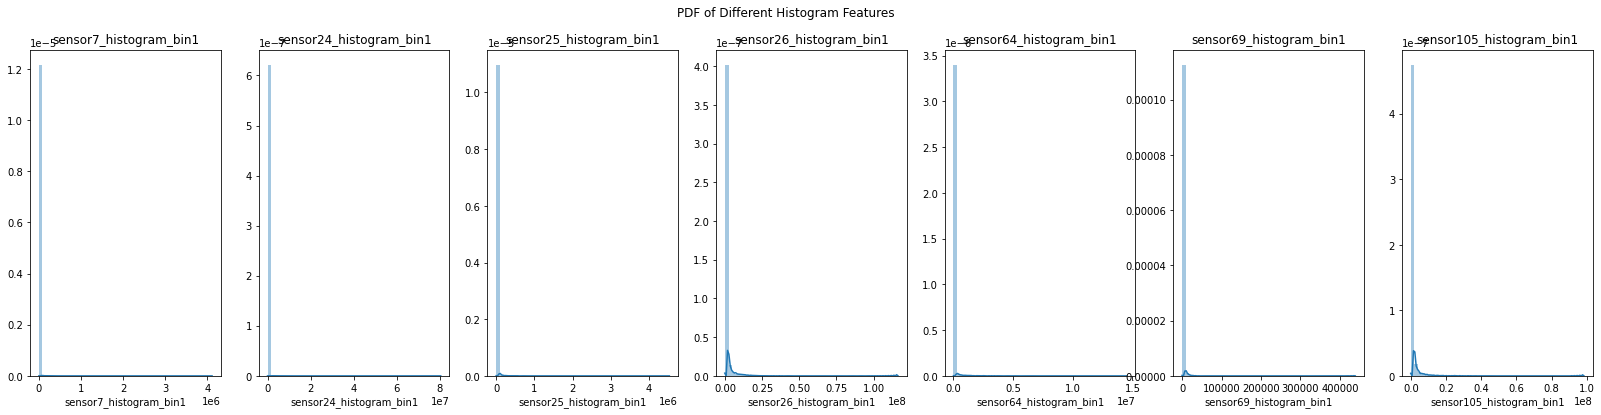

In [ ]:
histograms=['sensor7_histogram_bin1','sensor24_histogram_bin1','sensor25_histogram_bin1','sensor26_histogram_bin1','sensor64_histogram_bin1','sensor69_histogram_bin1','sensor105_histogram_bin1']
fig=plt.figure(figsize=(28,6))
for i,j in enumerate(histograms):
  fig.add_subplot(1,7,i+1)
  ax=sns.distplot(Data[j],kde=True)
  plt.title(j)
plt.suptitle("PDF of Different Histogram Features")
plt.show()



*   All the Histogram features are right skewed
*   Most of their values are 0



## Checking random Sensor_measure features and PDF based on the different percentage of NULL values present in them:

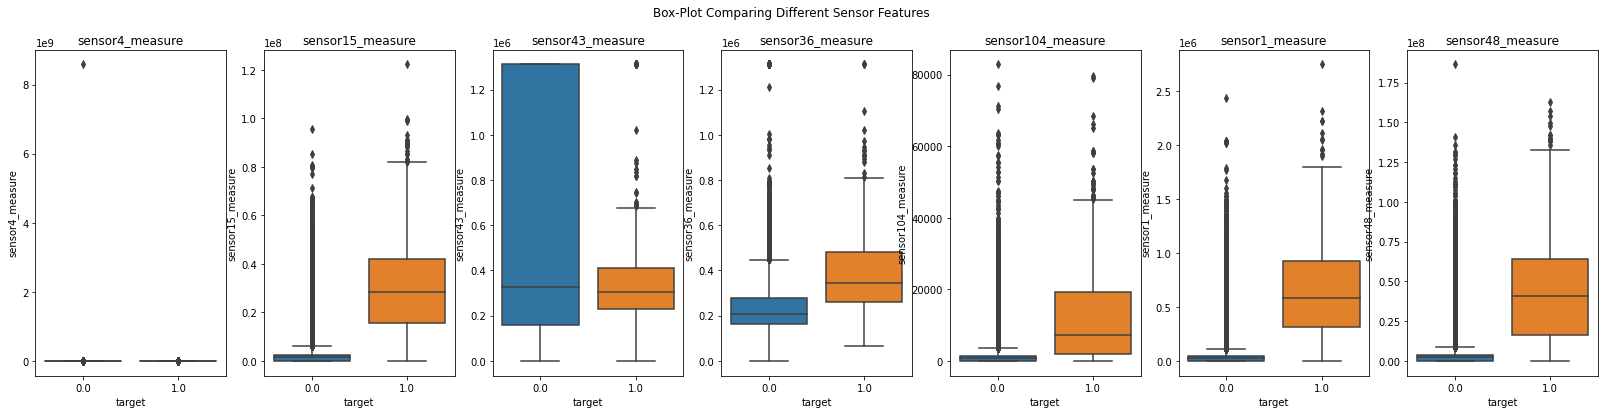

In [ ]:
sensors=['sensor4_measure','sensor15_measure','sensor43_measure','sensor36_measure','sensor104_measure' ,'sensor1_measure','sensor107_measure']
fig=plt.figure(figsize=(28,6))
for i,j in enumerate(sensors):
  fig.add_subplot(1,7,i+1)
  ax=sns.boxplot(x=Data['target'],y=Data[j])
  plt.title(j)
plt.suptitle("Box-Plot Comparing Different Sensor Features")
plt.show()

*  Rather than taking all the sensor measure features and plotting the box-plot I have taken different features based on the number of Nan values percentage present in them.

*   sensor4_measure isn't interpretable
*   sensor15_measure ,IQR range of class 0 points are distinguishable from IQR range of class 1 points but many points of class 0 are oultiers
*   sensor25_histogram_bin1 isn't interpretable

*   sensor43_measure,is able to classify class 1 and class 0 well . Class 0 has no outliers. Their 50th percentile is almost the same.
*   sensor36_measure,is able to classify class 1 and 0.The IQR also differs for both the classes .But there are many outliers for the class 0.


*   sensor1_measure is able to classify class 1. It clearly distingushes the various percentiles of class 1 but does not do a good job for class 0
*   sensor107_measure is not interpretable

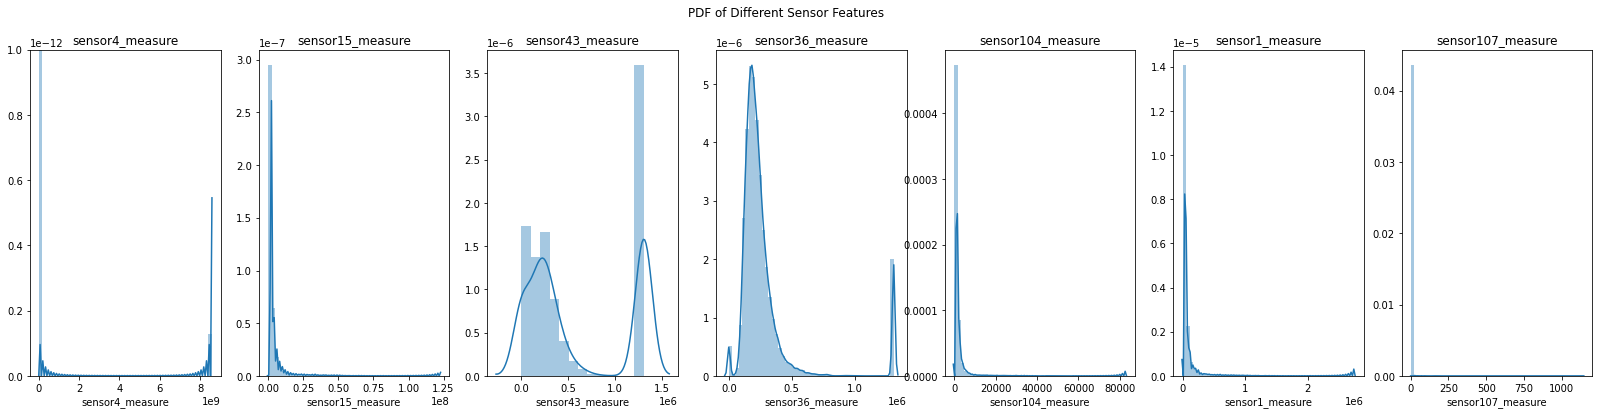

In [ ]:
sensors=['sensor4_measure','sensor15_measure','sensor43_measure','sensor36_measure','sensor104_measure' ,'sensor1_measure','sensor107_measure']
fig=plt.figure(figsize=(28,6))
for i,j in enumerate(sensors):
  fig.add_subplot(1,7,i+1)
  ax=sns.distplot(Data[j],kde=True)
  plt.title(j)
plt.suptitle("PDF of Different Sensor Features")
plt.show()



*   Most of the sensor values are 0
*   Sensor43_measure has most of its values between 0 to 0.8 and 1 to 1.6
*   Sensor36_measure has most of its values between 0 to 0.5 and few values above 1






## Multivariate Analysis

## Observing the heatmaps of sensor histogram bins :

In [ ]:
#Randomly choose 4 random histogram bins from the above analysis to plot heatmaps
feature1=['sensor7_histogram_bin0','sensor7_histogram_bin1',
          'sensor7_histogram_bin2','sensor7_histogram_bin3',
          'sensor7_histogram_bin4','sensor7_histogram_bin5',
          'sensor7_histogram_bin6','sensor7_histogram_bin7',
          'sensor7_histogram_bin8','sensor7_histogram_bin9']
feature2=['sensor105_histogram_bin0','sensor105_histogram_bin1',
 'sensor105_histogram_bin2' ,'sensor105_histogram_bin3',
 'sensor105_histogram_bin4', 'sensor105_histogram_bin5',
 'sensor105_histogram_bin6' ,'sensor105_histogram_bin7',
 'sensor105_histogram_bin8' ,'sensor105_histogram_bin9' ]
feature3=['sensor26_histogram_bin0','sensor26_histogram_bin1',
 'sensor26_histogram_bin2' ,'sensor26_histogram_bin3',
 'sensor26_histogram_bin4', 'sensor26_histogram_bin5',
 'sensor26_histogram_bin6' ,'sensor26_histogram_bin7',
 'sensor26_histogram_bin8' ,'sensor26_histogram_bin9' ]
feature4=['sensor69_histogram_bin0','sensor69_histogram_bin1',
 'sensor69_histogram_bin2' ,'sensor69_histogram_bin3',
 'sensor69_histogram_bin4', 'sensor69_histogram_bin5',
 'sensor69_histogram_bin6' ,'sensor69_histogram_bin7',
 'sensor69_histogram_bin8' ,'sensor69_histogram_bin9' ]
heatmap=[feature1,feature2,feature3,feature4]

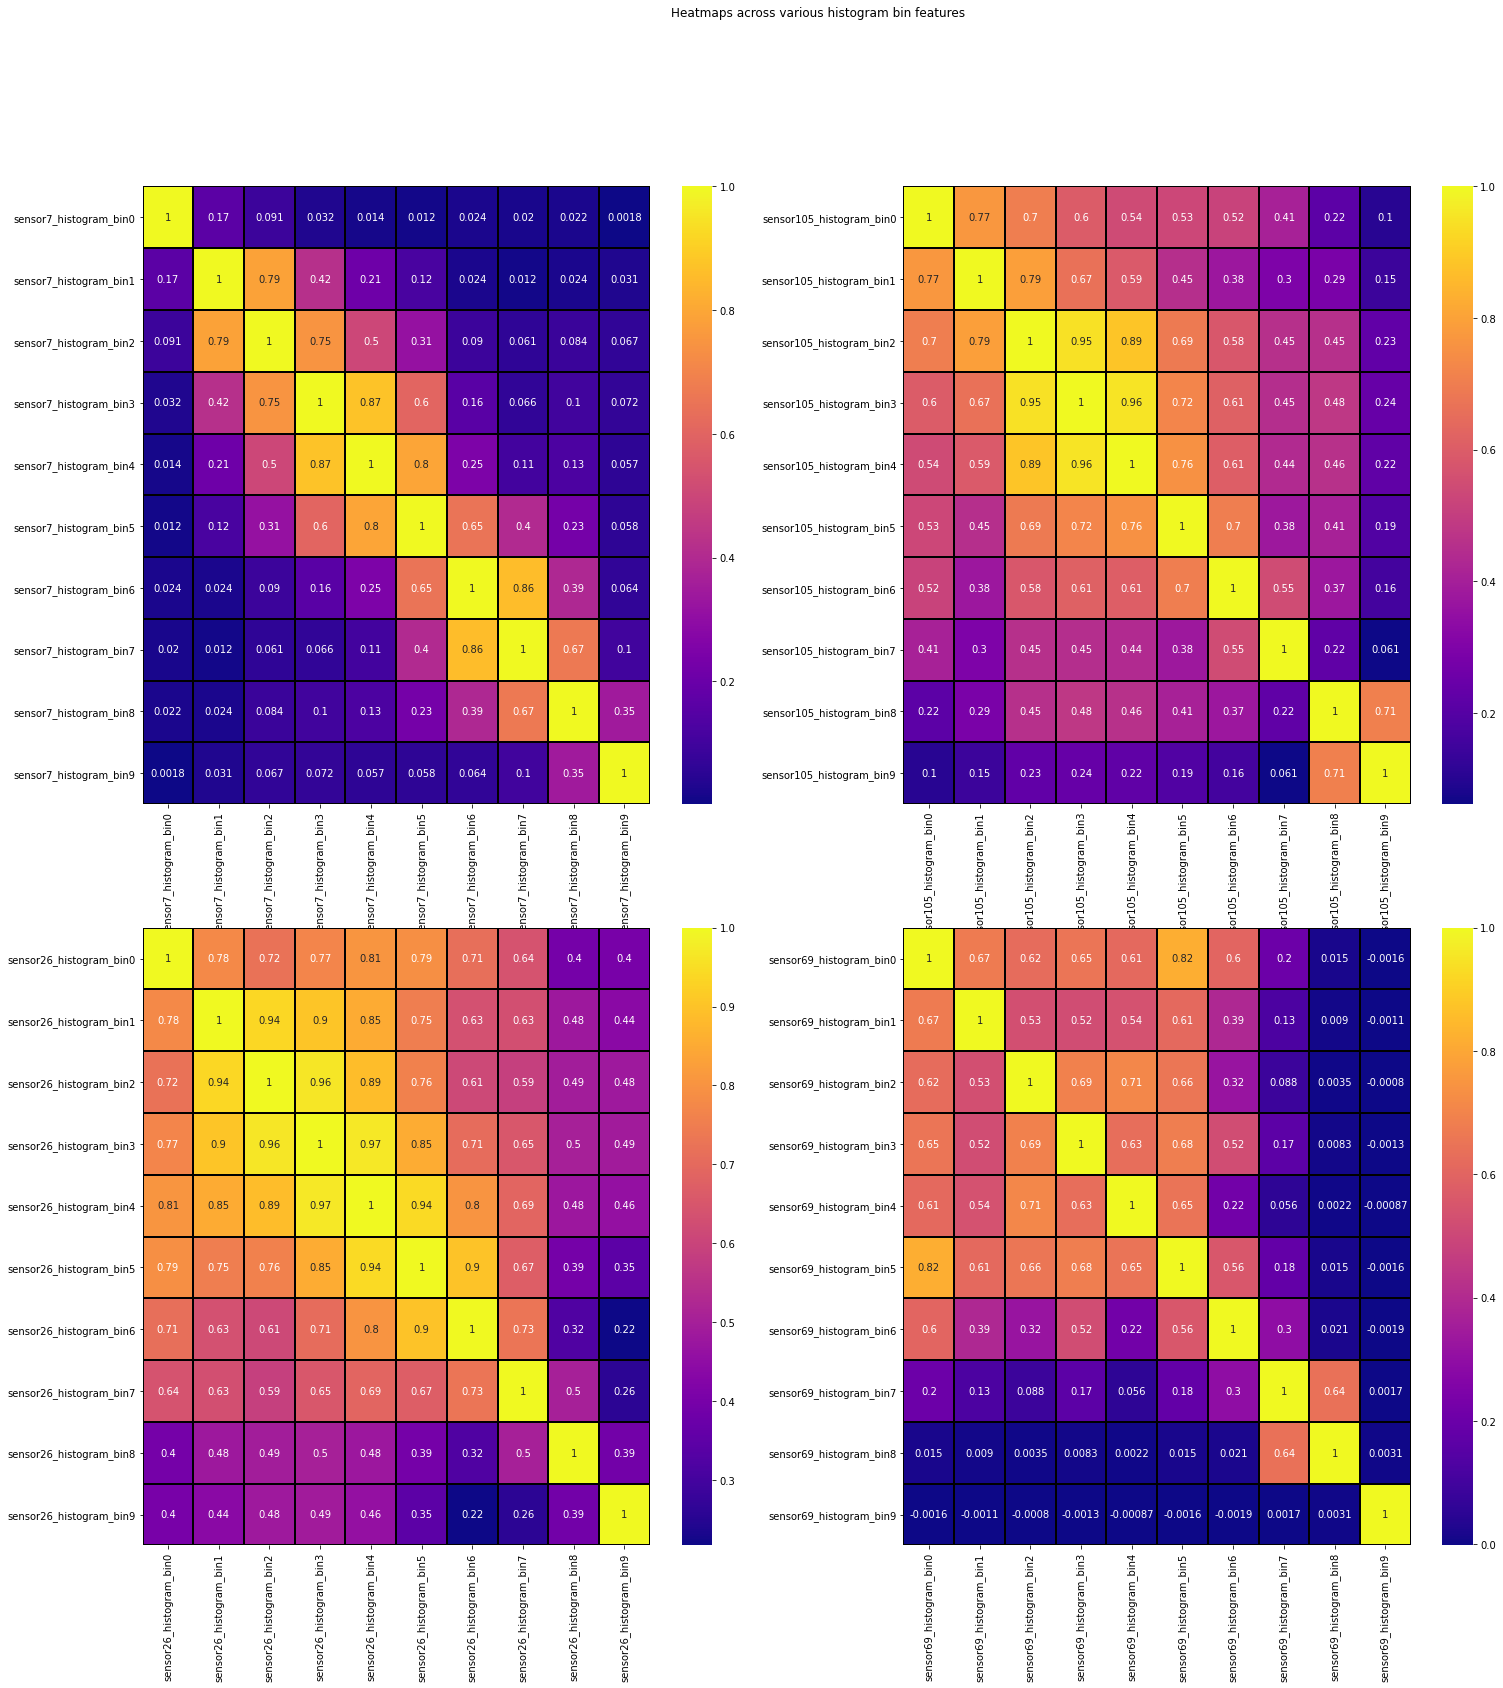

In [ ]:
fig=plt.figure(figsize=(25,25))
for i,j in enumerate(heatmap):
  new1 = Data.filter(j, axis=1)
  fig.add_subplot(2,2,i+1)
  sns.heatmap(new1.corr(),cmap ='plasma',linecolor ='black', linewidths = 1,annot=True)
plt.suptitle("Heatmaps across various histogram bin features")
plt.show()


* Most of the histogram features which are present are in the form of sensor(n) and sensor(n+1) 
* There might exist a time based relationship among the consecutive histogram bin features

## Data Preprocessing

In [6]:
X=Data.drop('target',axis=1)
X=X.drop('id',axis=1)
Y=Data.target
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, stratify=Y,random_state=60)
X_train, X_cv, y_train,y_cv = train_test_split(X_train, y_train, test_size=0.15,stratify=y_train,random_state=60)

In [7]:
redundant=[]
print("These features have more than or equal to 95% of their datapoints as 0 which does not contribute much to training :")
for i in X_train.columns:
  if (X_train[i]==0).sum()>38760 and i!='target':
    X_train.drop(i,inplace=True,axis=1)
    redundant.append(i)
    print(i)

These features have more than or equal to 95% of their datapoints as 0 which does not contribute much to training :
sensor7_histogram_bin0
sensor7_histogram_bin1
sensor19_measure
sensor21_measure
sensor24_histogram_bin0
sensor24_histogram_bin1
sensor24_histogram_bin2
sensor24_histogram_bin3
sensor24_histogram_bin4
sensor24_histogram_bin9
sensor25_histogram_bin9
sensor64_histogram_bin0
sensor100_measure
sensor106_measure


###Removing features with less than 80 percent variability 

In [8]:
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=80)
var_thres.fit( X_train)
constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[var_thres.get_support()]] #Checking every columns if it is greater than the given threshold or not and storing them in constant_columns

for column in constant_columns:
  if column!='target':
    X_train.drop(column,axis=1,inplace=True)#dropping the constant columns
    redundant.append(column)
    print(column)

sensor2_measure
sensor18_measure
sensor54_measure
sensor58_measure
sensor107_measure


In [9]:
Columns_check=X_train.columns.copy()
X_train = X_train.loc[:,X_train.isnull().mean() < .75] #remove columns with more than 75% of their features as NULL
redundant.extend(list((set(Columns_check)-set(X_train.columns))))
#X_train.drop_duplicates(keep='first',inplace=True) # drop duplicate rows
print("The columns which have been removed are",(set(Columns_check)-set(X_train.columns)))

The columns which have been removed are {'sensor42_measure', 'sensor41_measure', 'sensor40_measure', 'sensor43_measure', 'sensor68_measure'}


In [10]:
def impute_nan(Median_data,variable,median):
    Median_data[variable+"_median"]=Median_data[variable].fillna(median) 

In [11]:
#from tqdm import tqdm
med=dict()
Median_data=X_train.copy()    #create a copy the original data
median_name=[]
variable_name=[]
for i in tqdm(Median_data.columns):
  median_name.append(i+"_median")     
  variable_name.append(i)                     #trying to impute the data with median as the data is highly skewed
  median=Median_data[i].median()
  impute_nan(Median_data,i,median)
  med[i]=median
zip_median=zip(median_name,variable_name)


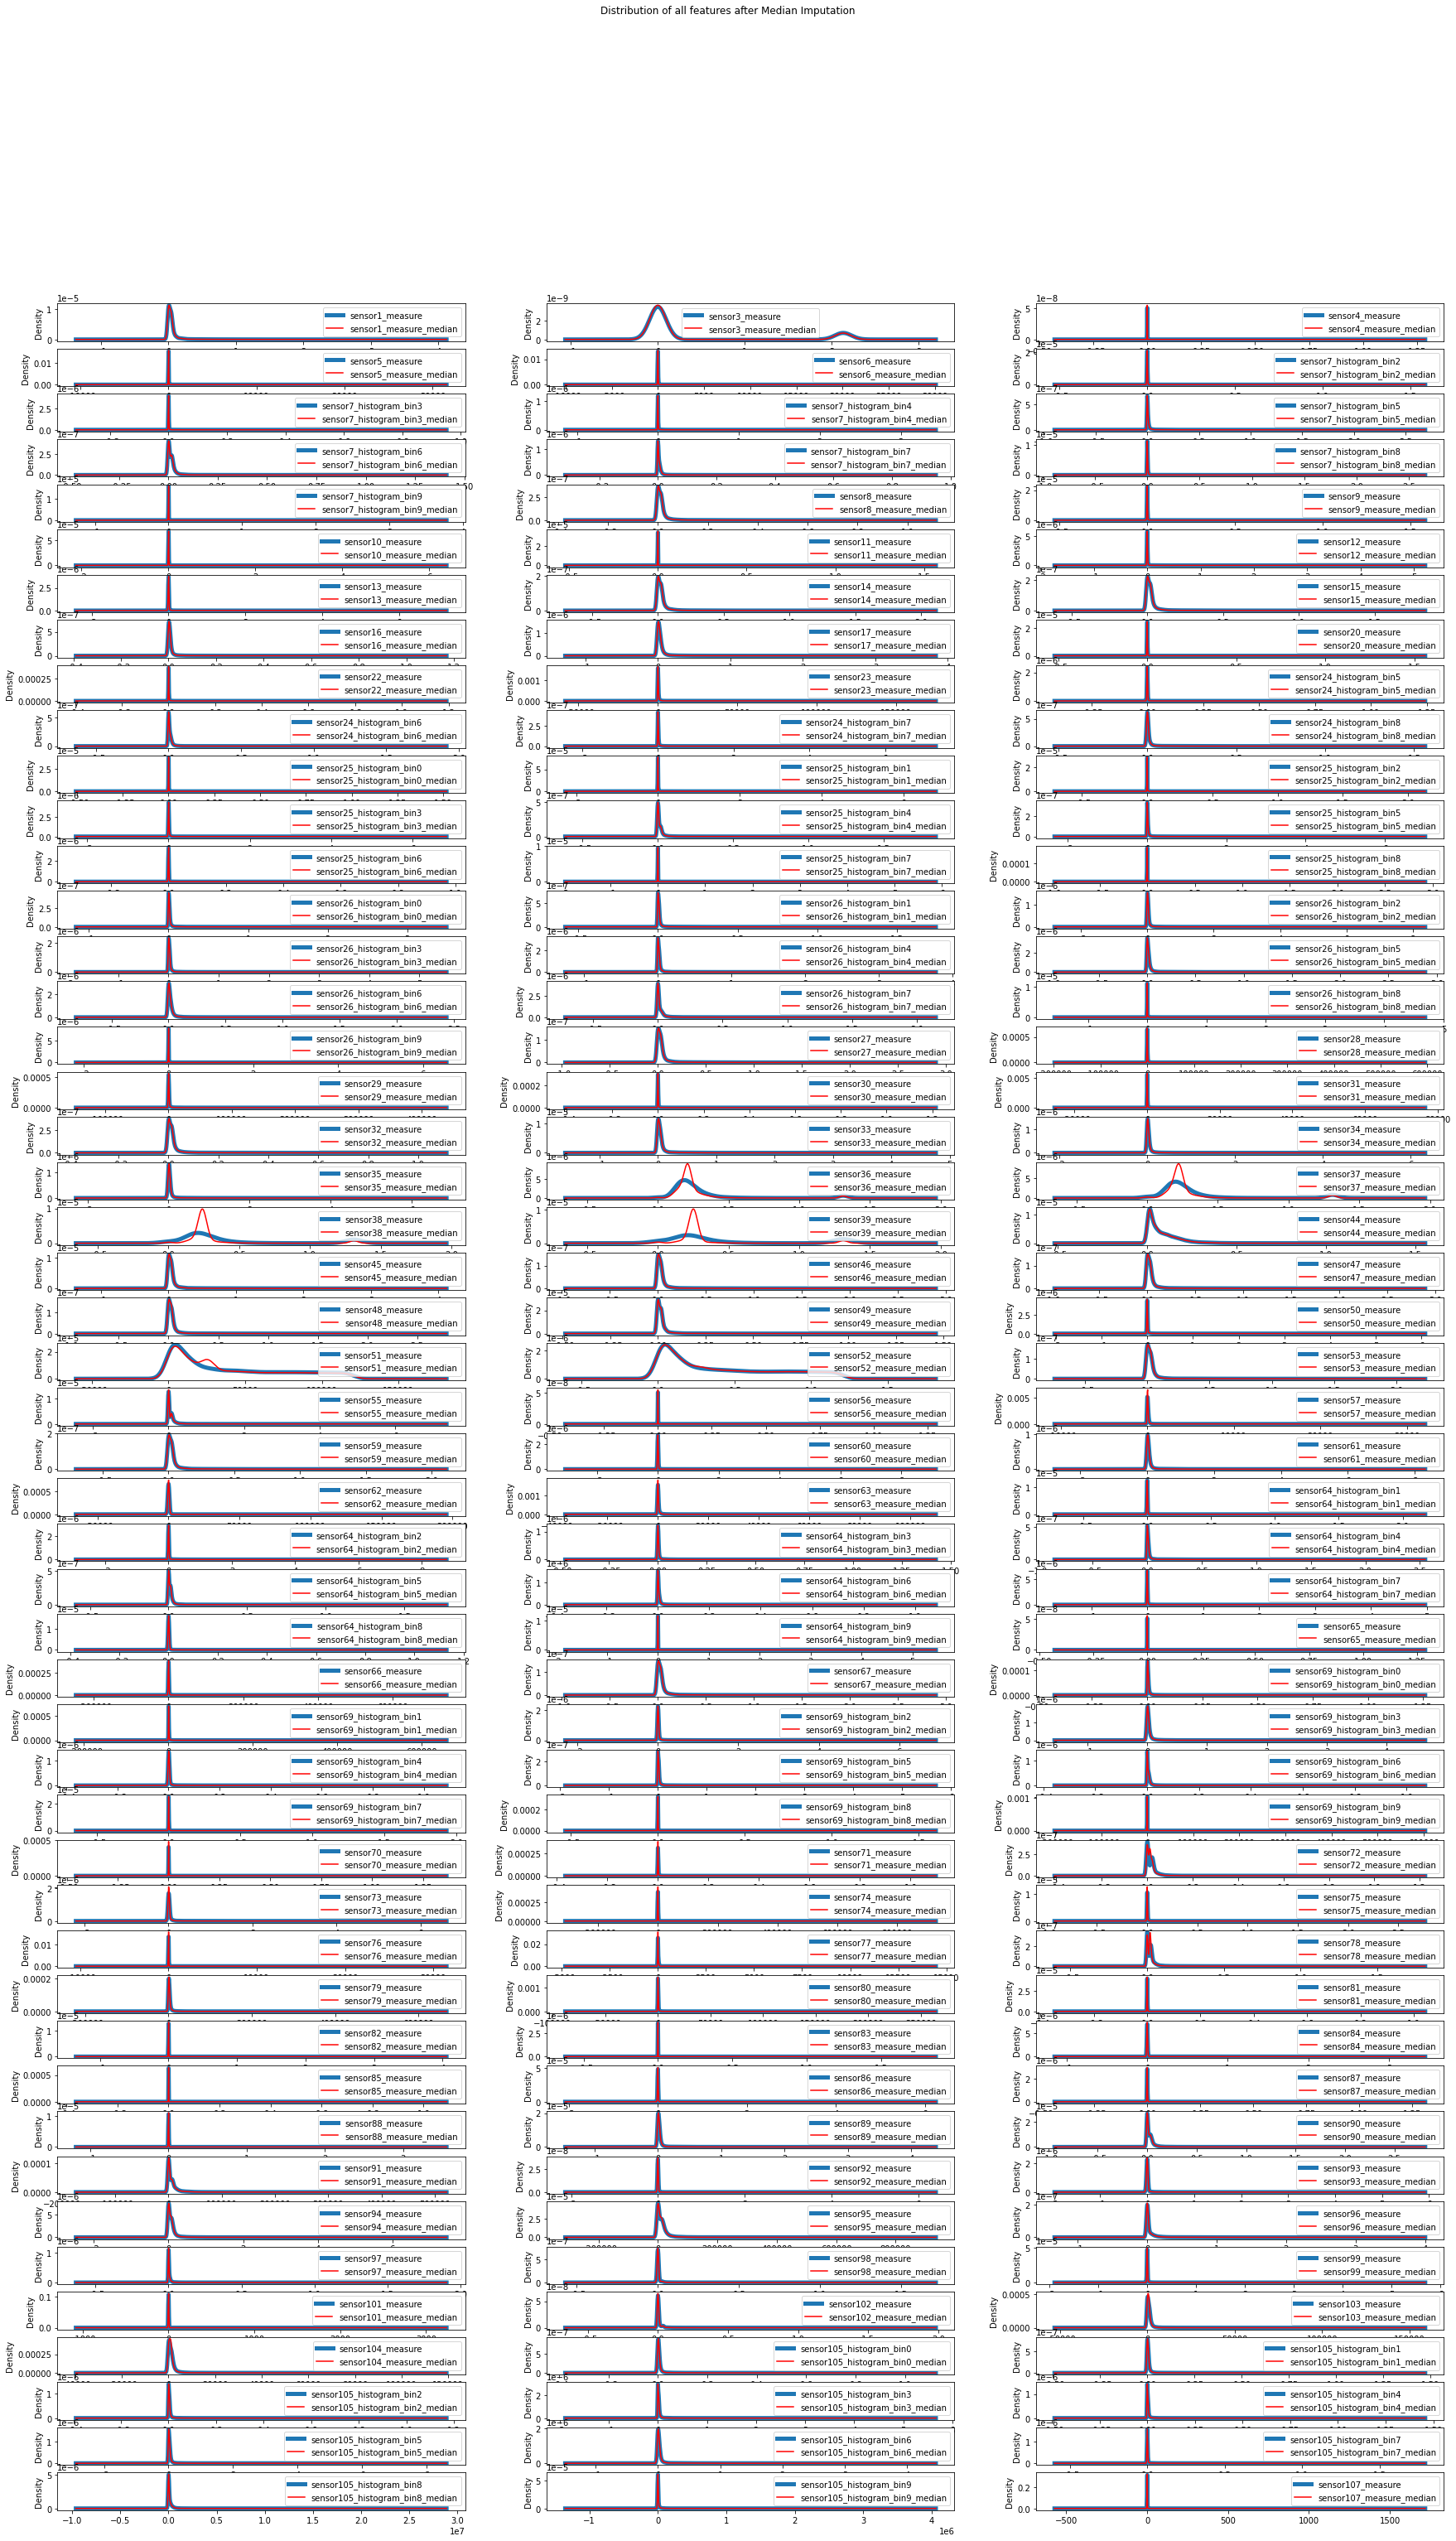

In [ ]:
fig=plt.figure(figsize=(30,50))
count=0
for i,j in tqdm(zip_median): 
  ax=fig.add_subplot(50,3,count+1)
  try:
    
    Median_data[j].plot(kind='kde',ax=ax,linewidth=5.0) 
    Median_data[i].plot(kind='kde', ax=ax, color='red')
    lines,labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
    count=count+1
  except:
    continue
plt.suptitle("Distribution of all features after Median Imputation")
plt.show()

In [ ]:
for i,j in zip_median:
  try:
    if ((Median_data[j].std()-Median_data[i].std())/Median_data[j].std())>0.10:
      print("The feature {} has {}% change from its original standard deviation after median imputation".format(j,((Median_data[j].std()-Median_data[i].std())/Median_data[j].std())*100))
  except:
    pass


The feature sensor4_measure has 13.196750846632682% change from its original standard deviation after median imputation
The feature sensor36_measure has 20.40532405221938% change from its original standard deviation after median imputation
The feature sensor37_measure has 24.571198545156083% change from its original standard deviation after median imputation
The feature sensor38_measure has 38.765116316732026% change from its original standard deviation after median imputation
The feature sensor39_measure has 44.55731474111716% change from its original standard deviation after median imputation
The feature sensor56_measure has 13.19675155774123% change from its original standard deviation after median imputation
The feature sensor57_measure has 13.033623567186009% change from its original standard deviation after median imputation
The feature sensor65_measure has 13.196750833042584% change from its original standard deviation after median imputation
The feature sensor70_measure has 12.



*   We can observe that median imputation is fine for most of the features except few of them
*   There is a significant change in the standard deviation of few features after median imputation as shown above .

* For features with less than 10% chance in their standard deviation we shall impute the missing values with median. For the remaining features we shall try another approach.





In [12]:
features=['sensor4_measure','sensor36_measure','sensor37_measure','sensor38_measure','sensor39_measure','sensor56_measure',
          'sensor57_measure','sensor65_measure',
          'sensor70_measure','sensor71_measure','sensor72_measure','sensor73_measure','sensor74_measure',
          'sensor75_measure','sensor76_measure','sensor77_measure','sensor78_measure']

Random_impute=X_train[features].copy()


In [165]:
imputer = mdi.RandomSampleImputer(random_state=42)
imputer.fit(Random_impute)

# transform the data
train_t = imputer.transform(Random_impute)

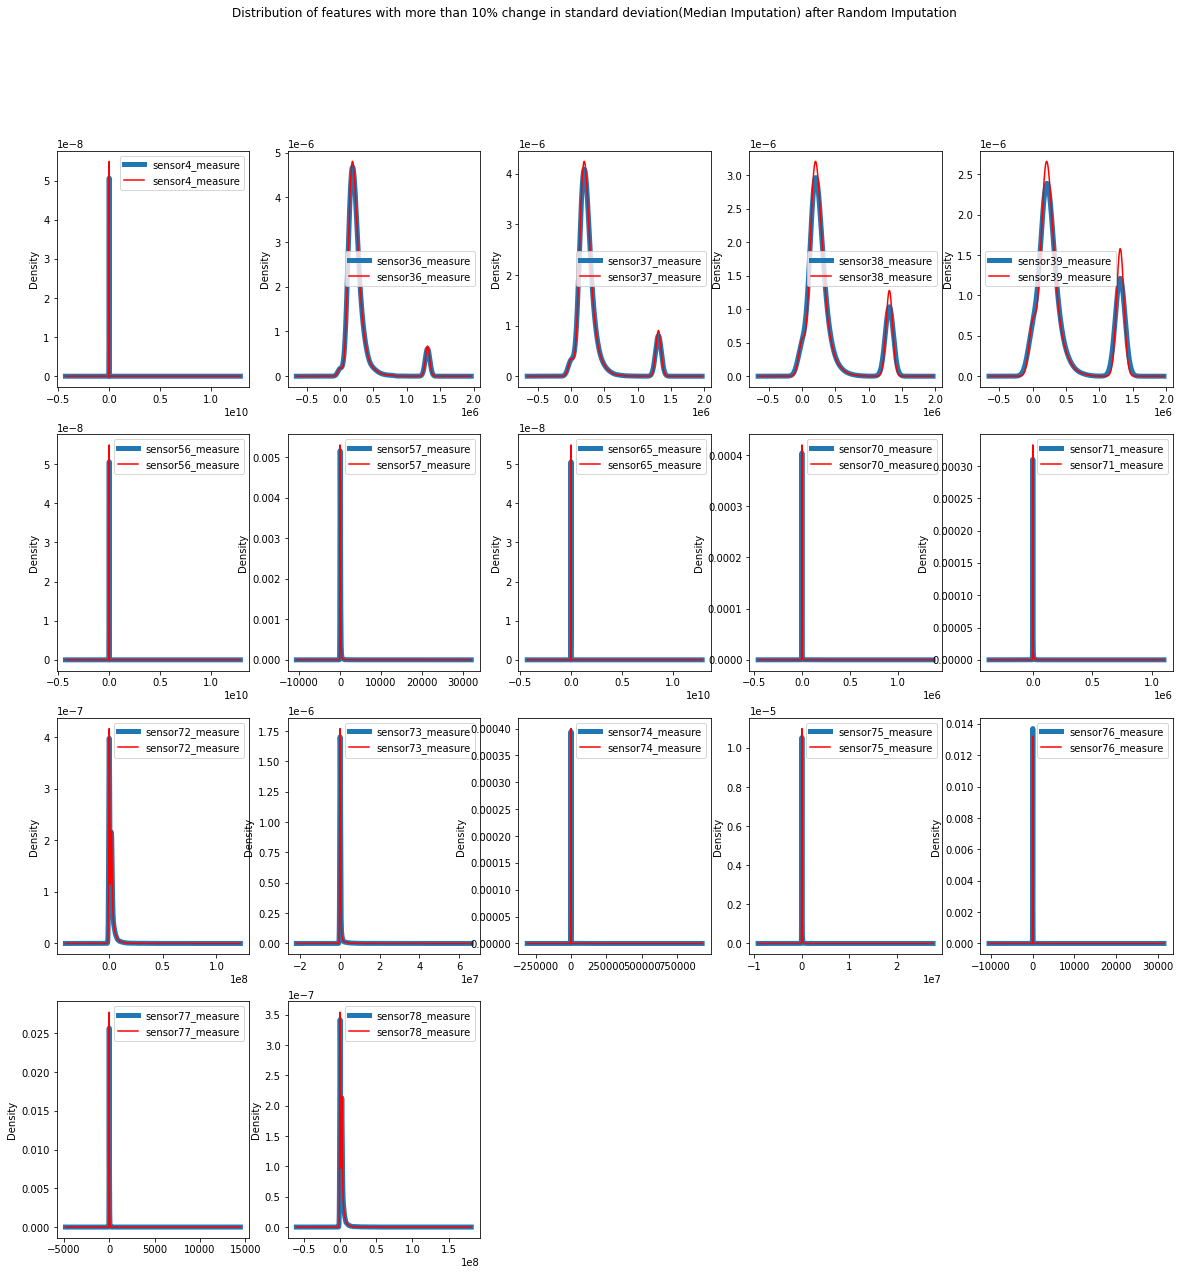

In [ ]:
fig=plt.figure(figsize=(20,20))
count=0
for j in tqdm(train_t.columns): 
  ax=fig.add_subplot(4,5,count+1)
  count=count+1
  X_train[j].plot(kind='kde',ax=ax,linewidth=5.0) 
  train_t[j].plot(kind='kde', ax=ax, color='red')
  lines,labels = ax.get_legend_handles_labels()
  ax.legend(lines, labels, loc='best')
plt.suptitle("Distribution of features with more than 10% change in standard deviation(Median Imputation) after Random Imputation ")
plt.show()

In [ ]:
for j in train_t.columns:
  if ((X_train[j].std()-train_t[j].std())/X_train[j].std())>0.10:
    print("The feature {} has {}% change from its original standard deviation after Random imputation".format(j,((X_train[j].std()-train_t[j].std())/X_train[j].std())*100))

The feature sensor4_measure has 13.196751514777342% change from its original standard deviation after Random imputation
The feature sensor56_measure has 13.196751639941503% change from its original standard deviation after Random imputation
The feature sensor65_measure has 13.196751627140465% change from its original standard deviation after Random imputation




*   It is evident that there are three features whose percentage change in variance is greater than 10% .
*   We shall fit the random features imputer on the remaining features excluding those 3 features



In [13]:
Random_impute=X_train[features].copy()
Random_impute.drop('sensor4_measure',axis=1,inplace=True)
Random_impute.drop('sensor56_measure',axis=1,inplace=True)
Random_impute.drop('sensor65_measure',axis=1,inplace=True)
imputer = mdi.RandomSampleImputer(random_state=42)
imputer.fit(Random_impute)

# transform the data
train_t = imputer.transform(Random_impute)



*   After experimenting with random imputation we can observe that the number of features with standard deviation less than 10% has decreased .
*   There are 3 more features with standard deviation greater than 105 after random imputation . We shall try other approaches for this feature



In [14]:
Standarad_dev_data=X_train.copy()
std_features=['sensor4_measure','sensor56_measure','sensor65_measure']
Standarad_dev_name=[]
variable_name=[]
standard=dict()
def impute_nan(Standarad_dev_data,variable,dev):
    Standarad_dev_data[variable+"_std"]=Standarad_dev_data[variable].fillna(dev)
for i in tqdm(Standarad_dev_data.columns):
  if i in std_features:
    Standarad_dev_name.append(i+"_std")
    variable_name.append(i)
    dev=(Standarad_dev_data[i].std())
    standard[i]=dev
    impute_nan(Standarad_dev_data,i,dev)
zip_std=zip(Standarad_dev_name,variable_name)

In [ ]:
for i,j in zip_std:
  if ((Standarad_dev_data[j].std()-Standarad_dev_data[i].std())/Standarad_dev_data[j].std())>0.10:
    print("The feature {} has {}% change from its original standard deviation after Standard Deviation imputation".format(j,((Standarad_dev_data[j].std()-Standarad_dev_data[i].std())/Standarad_dev_data[j].std())*100))
  else:
    print("The feature {} has {}% change from its original standard deviation after Standard Deviation imputation".format(j,((Standarad_dev_data[j].std()-Standarad_dev_data[i].std())/Standarad_dev_data[j].std())*100))

The feature sensor4_measure has 3.195538764386526% change from its original standard deviation after Standard Deviation imputation
The feature sensor56_measure has 3.1953793518211504% change from its original standard deviation after Standard Deviation imputation
The feature sensor65_measure has 3.19549490026056% change from its original standard deviation after Standard Deviation imputation


3it [00:07,  2.42s/it]


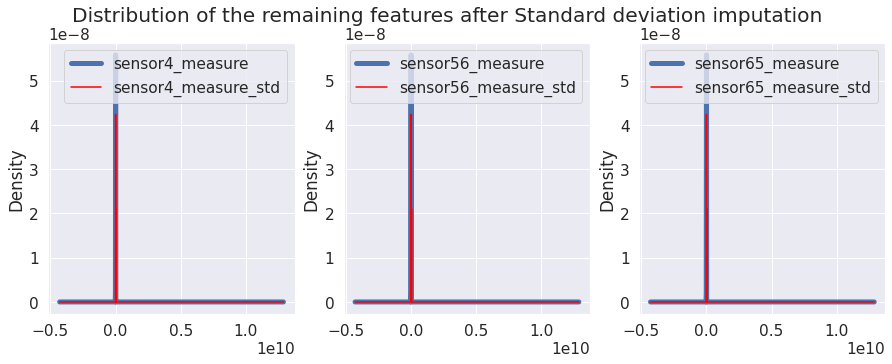

In [ ]:
fig=plt.figure(figsize=(15,5))
count=0
for i,j in tqdm(zip_std): 
  ax=fig.add_subplot(1,3,count+1)
  count=count+1
  Standarad_dev_data[j].plot(kind='kde',ax=ax,linewidth=5.0) 
  Standarad_dev_data[i].plot(kind='kde', ax=ax, color='red')
  lines,labels = ax.get_legend_handles_labels()
  ax.legend(lines, labels, loc='best')
plt.suptitle("Distribution of the remaining features after Standard deviation imputation  ")
plt.show()

In [40]:
try: 
    dictionary = open('standard_dev.pkl', 'wb') 
    pickle.dump(standard,dictionary) 
    dictionary.close() 
  
except: 
    print("Something went wrong")



* We can observe that imputing the missing values with the standard deviation is a better option as the variance is hardly lost.



## Impute Nan values with Median,Random Sampling and Standard Deviation

In [15]:
X_train['sensor4_measure']=Standarad_dev_data['sensor4_measure_std']
X_train['sensor56_measure']=Standarad_dev_data['sensor56_measure_std']
X_train['sensor65_measure']=Standarad_dev_data['sensor65_measure_std']
X_train['sensor36_measure']=train_t['sensor36_measure']
X_train['sensor37_measure']=train_t['sensor37_measure']
X_train['sensor38_measure']=train_t['sensor38_measure']
X_train['sensor39_measure']=train_t['sensor39_measure']
X_train['sensor57_measure']=train_t['sensor57_measure']
X_train['sensor70_measure']=train_t['sensor70_measure']
X_train['sensor71_measure']=train_t['sensor71_measure']
X_train['sensor72_measure']=train_t['sensor72_measure']
X_train['sensor73_measure']=train_t['sensor73_measure']
X_train['sensor74_measure']=train_t['sensor74_measure']
X_train['sensor75_measure']=train_t['sensor75_measure']
X_train['sensor76_measure']=train_t['sensor76_measure']
X_train['sensor77_measure']=train_t['sensor77_measure']
X_train['sensor78_measure']=train_t['sensor78_measure']

for i in X_train.columns:
  if i not in features:
    X_train[i]=Median_data[i+"_median"]


In [16]:
#https://kgptalkie.com/feature-selection-with-filtering-method-constant-quasi-constant-and-duplicate-feature-removal/
def get_correlation(data, threshold):
    corr_col = set()
    corrmat = data.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i, j])> threshold: #check if the correlation among the two features is greater than the given threshold
                colname = corrmat.columns[i]
                corr_col.add(colname) #add the column to the set
    return corr_col



*   There might be many correlated features in the dataset but dropping all of them will lead to some loss of information which might be crucial towards the models development




In [17]:
corrdata = X_train.corr().abs().stack()
corrdata = corrdata.sort_values(ascending=False)
corrdata = corrdata[corrdata>0.80] #selecting the pairs with correlation above 80%
corrdata = corrdata[corrdata<1]
corrdata = pd.DataFrame(corrdata).reset_index()
corrdata.columns = ['features1', 'features2', 'corr_value']
corrdata ##getting feature pairs with correlation greater than 80% stored and visualized in a dataframe(corrdata)

,features1,features2,corr_value
0,sensor67_measure,sensor47_measure,1.000000
1,sensor47_measure,sensor67_measure,1.000000
2,sensor67_measure,sensor46_measure,1.000000
3,sensor46_measure,sensor67_measure,1.000000
4,sensor46_measure,sensor47_measure,1.000000
...,...,...,...
711,sensor35_measure,sensor14_measure,0.800637
712,sensor69_histogram_bin4,sensor49_measure,0.800557
713,sensor49_measure,sensor69_histogram_bin4,0.800557
714,sensor69_histogram_bin5,sensor24_histogram_bin7,0.800164




*   There might be duplicate pairs in the dataframe . We shall remove the duplicate pairs from the dataframe



In [18]:
grouped_feature_list = []
correlated_groups_list = []
for feature in corrdata.features1.unique():
    if feature not in grouped_feature_list: #if the pair does not exist in the list
        correlated_block = corrdata[corrdata.features1 == feature]
        grouped_feature_list = grouped_feature_list + list(correlated_block.features2.unique()) + [feature]
        correlated_groups_list.append(correlated_block) #appending the feature to the list

### Dropping correlated features based on their importance using Random Forest



*   Dropping all of the correlated features might be a bad idea because there will be a loss of lot of information
*   We shall drop the correlated features based on least importance using Random Forest Classifier 



In [19]:
important_features = []
for group in tqdm(correlated_groups_list):
    features = list(group.features1.unique()) + list(group.features2.unique())
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(X_train[features], y_train) 
    
    importance = pd.concat([pd.Series(features), pd.Series(rf.feature_importances_)], axis = 1) #creating a dataframe using the feature importance
    importance.columns = ['features', 'importance'] #giving the column names
    importance.sort_values(by = 'importance', ascending = False, inplace = True)
    feat = importance.iloc[0]
    important_features.append(feat)

In [20]:
important_features = pd.DataFrame(important_features)
important_features.reset_index(inplace=True, drop = True)
important_features

,features,importance
0,sensor35_measure,0.100071
1,sensor13_measure,0.503388
2,sensor94_measure,0.509606
3,sensor59_measure,0.126638
4,sensor53_measure,0.115891
5,sensor78_measure,0.352731
6,sensor90_measure,0.513188
7,sensor103_measure,0.509986
8,sensor105_histogram_bin0,0.360205
9,sensor87_measure,0.513940


In [21]:
features_to_consider = set(important_features['features'])
features_to_discard = set(get_correlation(X_train,0.80)) - set(features_to_consider) #discarding the features with less importance
features_to_discard = list(features_to_discard)
X_train_grouped_uncorr = X_train.drop(labels = features_to_discard, axis = 1) 
X_train=X_train_grouped_uncorr

In [22]:
for i in redundant:
  X_test.drop(i,axis=1,inplace=True)
  X_cv.drop(i,axis=1,inplace=True)    #dropping the redundant features

In [23]:
features=['sensor4_measure','sensor36_measure','sensor37_measure','sensor38_measure','sensor39_measure','sensor56_measure',
          'sensor57_measure','sensor65_measure',
          'sensor70_measure','sensor71_measure','sensor72_measure','sensor73_measure','sensor74_measure',
          'sensor75_measure','sensor76_measure','sensor77_measure','sensor78_measure'] #the features which need random imputation and standard deviation imputation for their missing values


for i in X_cv.columns:
  if i not in features:
    X_cv[i].fillna(med[i],inplace=True) #imputing X_cv with the median values
  if i=='sensor4_measure' or i=='sensor56_measure' or i=='sensor65_measure':
    X_cv[i].fillna(standard[i],inplace=True) #imputing X_cv with the standard deviation values

'''
I have used to different loops for the cv and test data because I do not want any sort of data leakage or exposure to the cv data'''


for i in X_test.columns:
  if i not in features:
    X_test[i].fillna(med[i],inplace=True) #imputing X_test with the median values
  if i=='sensor4_measure' or i=='sensor56_measure' or i=='sensor65_measure':
    X_test[i].fillna(standard[i],inplace=True) #imputing X_test with the standard deviation values

In [24]:
Random_impute=X_test[features].copy()
Random_impute.drop('sensor4_measure',axis=1,inplace=True)
Random_impute.drop('sensor56_measure',axis=1,inplace=True)
Random_impute.drop('sensor65_measure',axis=1,inplace=True)
Random_impute_cv=X_cv[features].copy()
Random_impute_cv.drop('sensor4_measure',axis=1,inplace=True)
Random_impute_cv.drop('sensor56_measure',axis=1,inplace=True)
Random_impute_cv.drop('sensor65_measure',axis=1,inplace=True)

test_t = imputer.transform(Random_impute)
cv_t = imputer.transform(Random_impute_cv)


#random imputation for cv data
X_cv['sensor36_measure']=cv_t['sensor36_measure']
X_cv['sensor37_measure']=cv_t['sensor37_measure']
X_cv['sensor38_measure']=cv_t['sensor38_measure']
X_cv['sensor39_measure']=cv_t['sensor39_measure']
X_cv['sensor57_measure']=cv_t['sensor57_measure']
X_cv['sensor70_measure']=cv_t['sensor70_measure']
X_cv['sensor71_measure']=cv_t['sensor71_measure']
X_cv['sensor72_measure']=cv_t['sensor72_measure']
X_cv['sensor73_measure']=cv_t['sensor73_measure']
X_cv['sensor74_measure']=cv_t['sensor74_measure']
X_cv['sensor75_measure']=cv_t['sensor75_measure']
X_cv['sensor76_measure']=cv_t['sensor76_measure']
X_cv['sensor77_measure']=cv_t['sensor77_measure']
X_cv['sensor78_measure']=cv_t['sensor78_measure']



#random imputation for test data
X_test['sensor36_measure']=test_t['sensor36_measure']
X_test['sensor37_measure']=test_t['sensor37_measure']
X_test['sensor38_measure']=test_t['sensor38_measure']
X_test['sensor39_measure']=test_t['sensor39_measure']
X_test['sensor57_measure']=test_t['sensor57_measure']
X_test['sensor70_measure']=test_t['sensor70_measure']
X_test['sensor71_measure']=test_t['sensor71_measure']
X_test['sensor72_measure']=test_t['sensor72_measure']
X_test['sensor73_measure']=test_t['sensor73_measure']
X_test['sensor74_measure']=test_t['sensor74_measure']
X_test['sensor75_measure']=test_t['sensor75_measure']
X_test['sensor76_measure']=test_t['sensor76_measure']
X_test['sensor77_measure']=test_t['sensor77_measure']
X_test['sensor78_measure']=test_t['sensor78_measure']

In [25]:
for i in X_test.columns:
  if i not in X_train.columns:
    X_test.drop(i,inplace=True,axis=1)          #Finally discarding the columns which are not present in the train dataset


for i in X_cv.columns:                            
  if i not in X_train.columns:
    X_cv.drop(i,inplace=True,axis=1)


# Feature Engineering

###Log Transform on the top 5 features with the most number of unique values

In [26]:
count=0
print("The top 5 features with the most number of unique values are: ")
Columns=dict()
for i in X_train.columns:
  Columns[i]=len(X_train[i].unique())
for w in sorted(Columns,key=Columns.get, reverse=True):
  if  count!=5:
    print(w)
    count=count+1

The top 5 features with the most number of unique values are: 
sensor48_measure
sensor59_measure
sensor53_measure
sensor105_histogram_bin0
sensor69_histogram_bin6


In [27]:
X_train['sensor48_log']=np.log(X_train['sensor48_measure']+1)
X_train['sensor59_log']=np.log(X_train['sensor59_measure']+1)
X_train['sensor53_log']=np.log(X_train['sensor53_measure']+1)
X_train['sensor105_log']=np.log(X_train['sensor105_histogram_bin0']+1)
X_train['sensor69_histogram_bin6_log']=np.log(X_train['sensor69_histogram_bin6']+1)

X_test['sensor48_log']=np.log(X_test['sensor48_measure']+1)
X_test['sensor59_log']=np.log(X_test['sensor59_measure']+1)
X_test['sensor53_log']=np.log(X_test['sensor53_measure']+1)
X_test['sensor105_log']=np.log(X_test['sensor105_histogram_bin0']+1)
X_test['sensor69_histogram_bin6_log']=np.log(X_test['sensor69_histogram_bin6']+1)


X_cv['sensor48_log']=np.log(X_cv['sensor48_measure']+1)
X_cv['sensor59_log']=np.log(X_cv['sensor59_measure']+1)
X_cv['sensor54_log']=np.log(X_cv['sensor53_measure']+1)
X_cv['sensor106_log']=np.log(X_cv['sensor105_histogram_bin0']+1)
X_cv['sensor69_histogram_bin6_log']=np.log(X_cv['sensor69_histogram_bin6']+1)

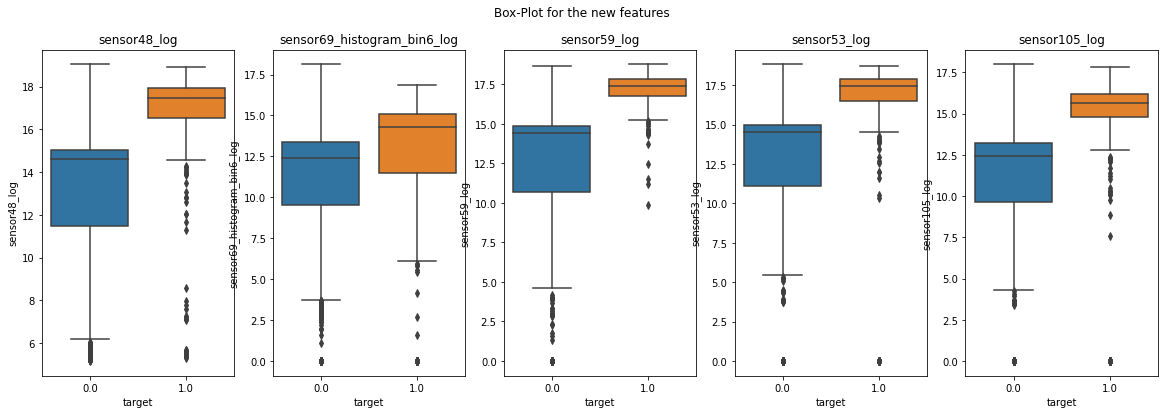

In [96]:
sensors=['sensor48_log','sensor69_histogram_bin6_log','sensor59_log','sensor53_log','sensor105_log']
fig=plt.figure(figsize=(20,6))
for i,j in enumerate(sensors):
  fig.add_subplot(1,5,i+1)
  ax=sns.boxplot(x=y_train,y=X_train[j])
  plt.title(j)
plt.suptitle("Box-Plot for the new features")
plt.show()



*  From the new features we can observe that in all cases the least value of the class 0 is always less than the least value of class 1 . This information might be useful in distinguishing between the classes .



###Exponentiation of the Sum of histogram features belonging to a sensor

In [28]:
X_train['histogram_sum_7']=(X_train['sensor7_histogram_bin2']+X_train['sensor7_histogram_bin3']+X_train['sensor7_histogram_bin4']+X_train['sensor7_histogram_bin5']+X_train['sensor7_histogram_bin6']+X_train['sensor7_histogram_bin8']+X_train['sensor7_histogram_bin9'])**(1/4)
X_train['histogram_sum_24']=(X_train['sensor24_histogram_bin5']+X_train['sensor24_histogram_bin6']+X_train['sensor24_histogram_bin7']+X_train['sensor24_histogram_bin8'])**(1/4)
X_train['histogram_sum_26']=(X_train['sensor26_histogram_bin7']+X_train['sensor26_histogram_bin8']+X_train['sensor26_histogram_bin9'])**(1/4)
X_train['histogram_sum_64']=(X_train['sensor64_histogram_bin7']+X_train['sensor64_histogram_bin1']+X_train['sensor64_histogram_bin9'])**(1/4)
X_train['histogram_sum_69']=(X_train['sensor69_histogram_bin1']+X_train['sensor69_histogram_bin6']+X_train['sensor69_histogram_bin7']+X_train['sensor69_histogram_bin8']+X_train['sensor69_histogram_bin9'])**(1/4)
X_train['histogram_sum_25']=(X_train['sensor25_histogram_bin0']+X_train['sensor25_histogram_bin1']+X_train['sensor25_histogram_bin2']+X_train['sensor25_histogram_bin3']+X_train['sensor25_histogram_bin4']+X_train['sensor25_histogram_bin6']+X_train['sensor25_histogram_bin7']+X_train['sensor25_histogram_bin8'])**(1/4)
X_train['histogram_sum_105']=(X_train['sensor105_histogram_bin0']+X_train['sensor105_histogram_bin1']+X_train['sensor105_histogram_bin5']+X_train['sensor105_histogram_bin6']+X_train['sensor105_histogram_bin8']+X_train['sensor105_histogram_bin9'])**(1/4)



X_test['histogram_sum_7']=(X_test['sensor7_histogram_bin2']+X_test['sensor7_histogram_bin3']+X_test['sensor7_histogram_bin4']+X_test['sensor7_histogram_bin5']+X_test['sensor7_histogram_bin6']+X_test['sensor7_histogram_bin8']+X_test['sensor7_histogram_bin9'])**(1/4)
X_test['histogram_sum_24']=(X_test['sensor24_histogram_bin5']+X_test['sensor24_histogram_bin6']+X_test['sensor24_histogram_bin7']+X_test['sensor24_histogram_bin8'])**(1/4)
X_test['histogram_sum_26']=(X_test['sensor26_histogram_bin7']+X_test['sensor26_histogram_bin8']+X_test['sensor26_histogram_bin9'])**(1/4)
X_test['histogram_sum_64']=(X_test['sensor64_histogram_bin7']+X_test['sensor64_histogram_bin1']+X_test['sensor64_histogram_bin9'])**(1/4)
X_test['histogram_sum_69']=(X_test['sensor69_histogram_bin1']+X_test['sensor69_histogram_bin6']+X_test['sensor69_histogram_bin7']+X_test['sensor69_histogram_bin8']+X_test['sensor69_histogram_bin9'])**(1/4)
X_test['histogram_sum_25']=(X_test['sensor25_histogram_bin0']+X_test['sensor25_histogram_bin1']+X_test['sensor25_histogram_bin2']+X_test['sensor25_histogram_bin3']+X_test['sensor25_histogram_bin4']+X_test['sensor25_histogram_bin6']+X_test['sensor25_histogram_bin7']+X_test['sensor25_histogram_bin8'])**(1/4)
X_test['histogram_sum_105']=(X_test['sensor105_histogram_bin0']+X_test['sensor105_histogram_bin1']+X_test['sensor105_histogram_bin5']+X_test['sensor105_histogram_bin6']+X_test['sensor105_histogram_bin8']+X_test['sensor105_histogram_bin9'])**(1/4)


X_cv['histogram_sum_7']=(X_cv['sensor7_histogram_bin2']+X_cv['sensor7_histogram_bin3']+X_cv['sensor7_histogram_bin4']+X_cv['sensor7_histogram_bin5']+X_cv['sensor7_histogram_bin6']+X_cv['sensor7_histogram_bin8']+X_cv['sensor7_histogram_bin9'])**(1/4)
X_cv['histogram_sum_24']=(X_cv['sensor24_histogram_bin5']+X_cv['sensor24_histogram_bin6']+X_cv['sensor24_histogram_bin7']+X_cv['sensor24_histogram_bin8'])**(1/4)
X_cv['histogram_sum_26']=(X_cv['sensor26_histogram_bin7']+X_cv['sensor26_histogram_bin8']+X_cv['sensor26_histogram_bin9'])**(1/4)
X_cv['histogram_sum_64']=(X_cv['sensor64_histogram_bin7']+X_cv['sensor64_histogram_bin1']+X_cv['sensor64_histogram_bin9'])**(1/4)
X_cv['histogram_sum_69']=(X_cv['sensor69_histogram_bin1']+X_cv['sensor69_histogram_bin6']+X_cv['sensor69_histogram_bin7']+X_cv['sensor69_histogram_bin8']+X_cv['sensor69_histogram_bin9'])**(1/4)
X_cv['histogram_sum_25']=(X_cv['sensor25_histogram_bin0']+X_cv['sensor25_histogram_bin1']+X_cv['sensor25_histogram_bin2']+X_cv['sensor25_histogram_bin3']+X_cv['sensor25_histogram_bin4']+X_cv['sensor25_histogram_bin6']+X_cv['sensor25_histogram_bin7']+X_cv['sensor25_histogram_bin8'])**(1/4)
X_cv['histogram_sum_105']=(X_cv['sensor105_histogram_bin0']+X_cv['sensor105_histogram_bin1']+X_cv['sensor105_histogram_bin5']+X_cv['sensor105_histogram_bin6']+X_cv['sensor105_histogram_bin8']+X_cv['sensor105_histogram_bin9'])**(1/4)




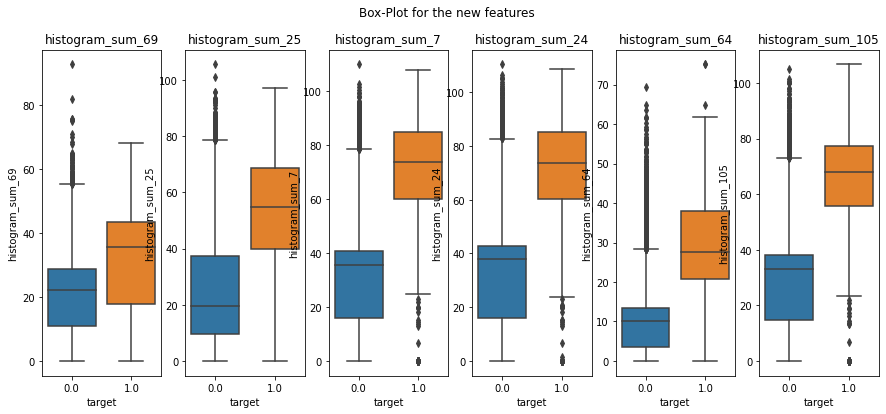

In [98]:
sensors=['histogram_sum_69','histogram_sum_25','histogram_sum_7','histogram_sum_24','histogram_sum_64','histogram_sum_105']
fig=plt.figure(figsize=(15,6))
for i,j in enumerate(sensors):
  fig.add_subplot(1,6,i+1)
  ax=sns.boxplot(x=y_train,y=X_train[j])
  plt.title(j)
plt.suptitle("Box-Plot for the new features")
plt.show()



*  From the new features we can observe that in all cases the maximum value of the class 1 is always greater than the maximum value of class 1 


*   We can observe the new features are able to distinguish one class from the another quite decently.



In [29]:
#https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
#using smote and randomundersampling!

over = SMOTE(sampling_strategy=0.1,random_state=60)
under = RandomUnderSampler(sampling_strategy=0.1,random_state=60) #Oversampling the minority class by 10% and undersampling the majority class by 10%

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)                                                         


# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train,y_train)
X_train=pd.DataFrame(X_train)
X_train.columns=X_cv.columns
y_train=pd.Series(y_train)



* As class 1 is highly imbalanced let us create synthetic points of class 1 by 10% and randomly remove 10% of datapoints from class 0



In [30]:
minimum=MinMaxScaler()
col=X_train.columns

#normalizing X_train,X_cv and X_test
X_train=minimum.fit_transform(X_train)
X_train=pd.DataFrame(X_train)
X_train.columns=col

X_cv=minimum.transform(X_cv)
X_cv=pd.DataFrame(X_cv)
X_cv.columns=col

X_test=minimum.transform(X_test)
X_test=pd.DataFrame(X_test)
X_test.columns=col

In [243]:
print("The shape of Training dataset")
print(X_train.shape, y_train.shape)
print("*"*50)
print("The shape of Cross Validation dataset")
print(X_cv.shape, y_cv.shape)
print("*"*50)
print("The shape of Test dataset")
print(X_test.shape, y_test.shape)
print("*"*50)

The shape of Training dataset
(44132, 115) (44132,)
**************************************************
The shape of Cross Validation dataset
(7200, 115) (7200,)
**************************************************
The shape of Test dataset
(12000, 115) (12000,)
**************************************************





* We are normalizing the data because the maximum value and minimum are very different from each other. This affects the performance of models like KNN.





# Modelling

In [31]:
def confusion_mat(test_y,predict_y):
    ''' Function to Visualize the Confusion Matrix'''
       
    labels = [0,1]
    plt.figure(figsize=(6,6))
    cmap=sns.light_palette("blue")
    C = confusion_matrix(test_y, predict_y)   
    print("Percentage of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    sns.heatmap(C, cmap="Blues",annot=True,annot_kws={"size": 16},fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Confusion matrix')
    
    plt.show()

### K-Nearest Neighbour Algorithm


F1 score for : 3 is 0.6122448979591838 
F1 score for : 5 is 0.613861386138614 
F1 score for : 7 is 0.5909090909090909 
F1 score for : 9 is 0.6095238095238096 
F1 score for : 11 is 0.6031746031746031 
F1 score for : 13 is 0.6148867313915858 

  Best alpha (hyperparameter) : 13 



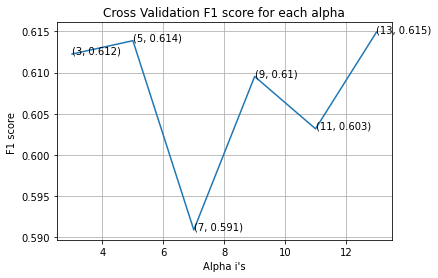


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  0.9164840516191867
F1_score for cv data :  0.6148867313915858
F1_score for test data :  0.6452905811623246
****************************************************************************************************
Confusion Matrix for the Train Data  

Percentage of misclassified points  1.5544276262122723


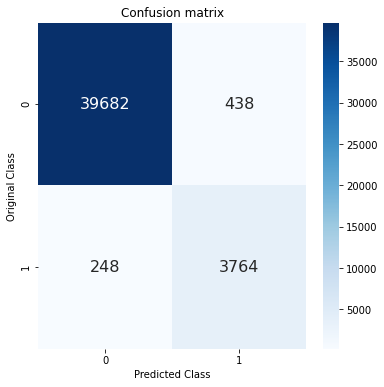

****************************************************************************************************
Confusion Matrix for the Test Data  

Percentage of misclassified points  1.4749999999999999


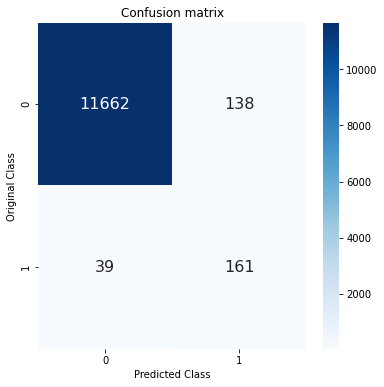

****************************************************************************************************


In [244]:
#Setting the range of best K's to select from
alpha = [x for x in range(3, 15, 2)]

#storing all the Cross validation f1 scores
cv_f1score_array=[]
for i in tqdm(alpha):
    KNN=KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    KNN.fit(X_train,y_train)
    predict_y = KNN.predict(X_cv)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))

#displaying the F1 score for all hyperparameters    
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#The best K after hyperparameter tuning
best_alpha_KNN = np.argmax(cv_f1score_array) 


print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha_KNN]  ,'\n')

#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots() 


#plotting hyperparameter v/s F1score  graph
ax.plot(alpha, cv_f1score_array) 
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("F1 score ")
plt.show()

#fitting the classifier with best hyperparameter
KNN=KNeighborsClassifier(n_neighbors=alpha[best_alpha_KNN],n_jobs=-1)
KNN.fit(X_train, y_train)

#predicting actual labels
pred_y=KNN.predict(X_test)

#displaying the perfomance metric for train,cv and test data
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = KNN.predict(X_train)
print ('F1 score for train data : ',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = KNN.predict(X_cv)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = KNN.predict(X_test)
print ('F1_score for test data : ',f1_score(y_test, pred_y_test, average='binary'))
print('*'*100)
print("Confusion Matrix for the Train Data ",'\n')
confusion_mat(y_train,pred_y_train)
print('*'*100)
print("Confusion Matrix for the Test Data ",'\n')
confusion_mat(y_test,pred_y_test)
print('*'*100)


## Logistic Regression


F1 score for : 1e-05 is 0.459546925566343 
F1 score for : 0.0001 is 0.4551282051282052 
F1 score for : 0.001 is 0.47352024922118374 
F1 score for : 0.01 is 0.5153374233128835 
F1 score for : 0.1 is 0.5471124620060791 
F1 score for : 1 is 0.6114649681528662 
F1 score for : 10 is 0.6225165562913908 
F1 score for : 100 is 0.6619718309859154 
F1 score for : 1000 is 0.6524822695035462 

  Best alpha (hyperparameter) : 100 



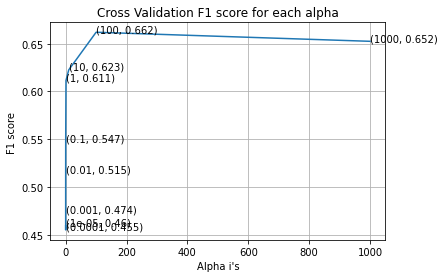


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  0.8712535835287986
F1_score for cv data :  0.6643109540636042
F1_score for test data :  0.7483296213808462
****************************************************************************************************
Confusion Matrix for the Train Data  

Percentage of misclassified points  2.238738330463156


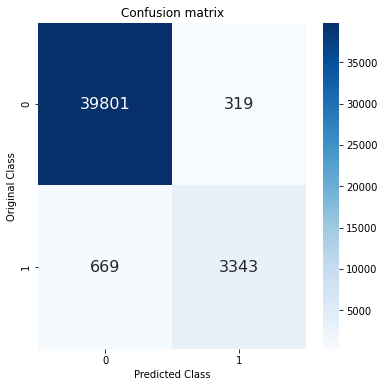

****************************************************************************************************
Confusion Matrix for the Test Data  

Percentage of misclassified points  0.9416666666666667


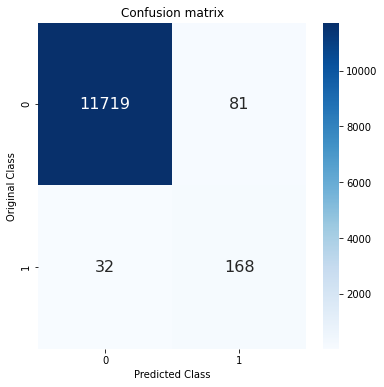

****************************************************************************************************


In [213]:
#Setting the range of best K's to select from
alpha = [10 ** x for x in range(-5, 4)]

#storing all the Cross validation f1 scores
cv_f1score_array=[]
for i in tqdm(alpha):
    logistic=LogisticRegression(penalty='l2',C=i,class_weight='balanced',n_jobs=-1)
    logistic.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logistic, method="sigmoid",cv=2)
    sig_clf.fit(X_train,y_train)
    predict_y = sig_clf.predict(X_cv)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))
#displaying the F1 score for all hyperparameters    
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#The best K after hyperparameter tuning
best_alpha= np.argmax(cv_f1score_array) 


print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha]  ,'\n')

#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots()

#plotting hyperparameter v/s F1score  graph
ax.plot(alpha, cv_f1score_array) 
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("F1 score ")
plt.show()

#fitting the classifier with best hyperparameter
logistic=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logistic.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logistic, method="sigmoid",cv=2)
sig_clf.fit(X_train, y_train)

#predicting actual labels
pred_y=sig_clf.predict(X_test)

#displaying the perfomance metric for train,cv and test data
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = sig_clf.predict(X_train)
print ('F1 score for train data : ',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = sig_clf.predict(X_cv)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = sig_clf.predict(X_test)
print ('F1_score for test data : ',f1_score(y_test, pred_y_test, average='binary'))
print('*'*100)
print("Confusion Matrix for the Train Data ",'\n')
confusion_mat(y_train,pred_y_train)
print('*'*100)
print("Confusion Matrix for the Test Data ",'\n')
confusion_mat(y_test,pred_y_test)
print('*'*100)

## Support Vector Machine


F1 score for : 0.0001 is 0.40071556350626125 
F1 score for : 0.001 is 0.44989775051124753 
F1 score for : 0.1 is 0.37924151696606784 
F1 score for : 1 is 0.18884892086330937 
F1 score for : 10 is 0.0 
F1 score for : 100 is 0.0 
F1 score for : 1000 is 0.0 

  Best alpha (hyperparameter) : 0.001 



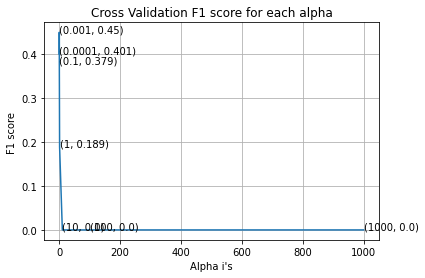


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  0.8037443511943191
F1_score for cv data :  0.4172932330827067
F1_score for test data :  0.4457547169811321
****************************************************************************************************
Confusion Matrix for the Train Data  

Percentage of misclassified points  4.133055379316596


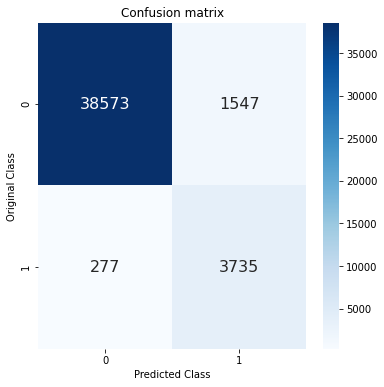

****************************************************************************************************
Confusion Matrix for the Test Data  

Percentage of misclassified points  3.916666666666667


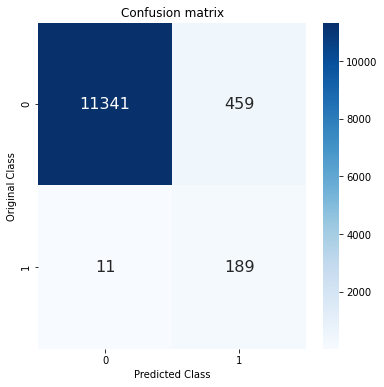

****************************************************************************************************


In [200]:
#Setting the range of hyperparameters to select from
alpha = [0.0001, 0.001, 0.1, 1, 10, 100,1000]

#storing all the Cross validation f1 scores
cv_f1score_array=[]
for i in tqdm(alpha):
    svm=SGDClassifier(alpha=i,loss='hinge',class_weight='balanced')
    svm.fit(X_train,y_train)
    predict_y =svm.predict(X_cv)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))
#displaying the F1 score for all hyperparameters    
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#The best K after hyperparameter tuning
best_alpha= np.argmax(cv_f1score_array) 


print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha]  ,'\n')

#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots() 

#plotting hyperparameter vs/s F1 score  graph
ax.plot(alpha, cv_f1score_array) 
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("F1 score ")
plt.show()

#fitting the classifier with best hyperparameter
svm=SGDClassifier(alpha=alpha[best_alpha],loss='hinge',class_weight='balanced')
svm.fit(X_train,y_train)

#predicting actual labels
pred_y=svm.predict(X_test)

#displaying the perfomance metric for train,cv and test data
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = svm.predict(X_train)
print ('F1 score for train data : ',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = svm.predict(X_cv)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = svm.predict(X_test)
print ('F1_score for test data : ',f1_score(y_test, pred_y_test, average='binary'))
print('*'*100)
print("Confusion Matrix for the Train Data ",'\n')
confusion_mat(y_train,pred_y_train)
print('*'*100)
print("Confusion Matrix for the Test Data ",'\n')
confusion_mat(y_test,pred_y_test)
print('*'*100)

#Random Forest


F1 score for : 10 is 0.7591836734693876 
F1 score for : 50 is 0.753968253968254 
F1 score for : 100 is 0.7818930041152262 
F1 score for : 500 is 0.7736625514403292 
F1 score for : 1000 is 0.7741935483870969 
F1 score for : 2000 is 0.7804878048780488 

  Best alpha (hyperparameter) : 100 



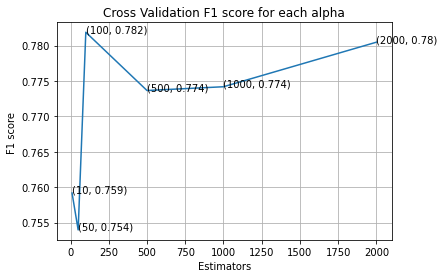


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  1.0
F1_score for cv data :  0.7755102040816326
F1_score for test data :  0.8112244897959185
****************************************************************************************************
Confusion Matrix for the Train Data  

Percentage of misclassified points  0.0


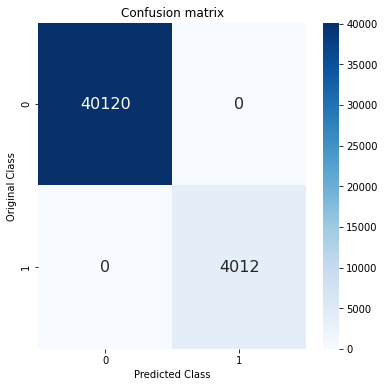

****************************************************************************************************
Confusion Matrix for the Test Data  

Percentage of misclassified points  0.6166666666666667


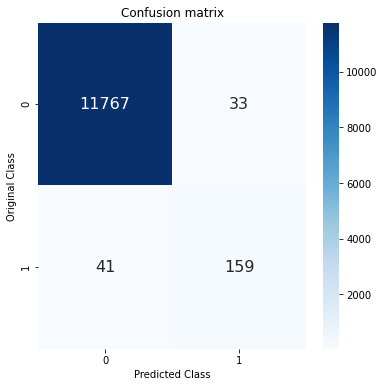

****************************************************************************************************


In [201]:
#choosing the best hyperparameters

alpha=[10,50,100,500,1000,2000]

#storing the f1 score for all hyperparameters in an array
cv_f1score_array=[]
for i in tqdm(alpha):
    random_forest=RandomForestClassifier(n_estimators=i,n_jobs=-1)
    random_forest.fit(X_train,y_train)
    predict_y = random_forest.predict(X_cv)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))

#displaying the F1 score for all hyperparameters      
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#best hyperparameter
best_alpha = np.argmax(cv_f1score_array)

print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha]  ,'\n')

#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots() 

#plotting hyperparameter V/S F1score  graph
ax.plot(alpha, cv_f1score_array) 
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Estimators")
plt.ylabel("F1 score ")
plt.show()


#fitting the classifier with best hyperparameter
random_forest=RandomForestClassifier(n_estimators=alpha[best_alpha],n_jobs=-1)
random_forest.fit(X_train, y_train)

#predicting actual labels
pred_y=random_forest.predict(X_test)

#displaying the perfomance metric for train,cv and test data
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = random_forest.predict(X_train)
print ('F1 score for train data : ',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = random_forest.predict(X_cv)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = random_forest.predict(X_test)
print ('F1_score for test data : ',f1_score(y_test, pred_y_test, average='binary'))
print('*'*100)
print("Confusion Matrix for the Train Data ",'\n')
confusion_mat(y_train,pred_y_train)
print('*'*100)
print("Confusion Matrix for the Test Data ",'\n')
confusion_mat(y_test,pred_y_test)
print('*'*100)


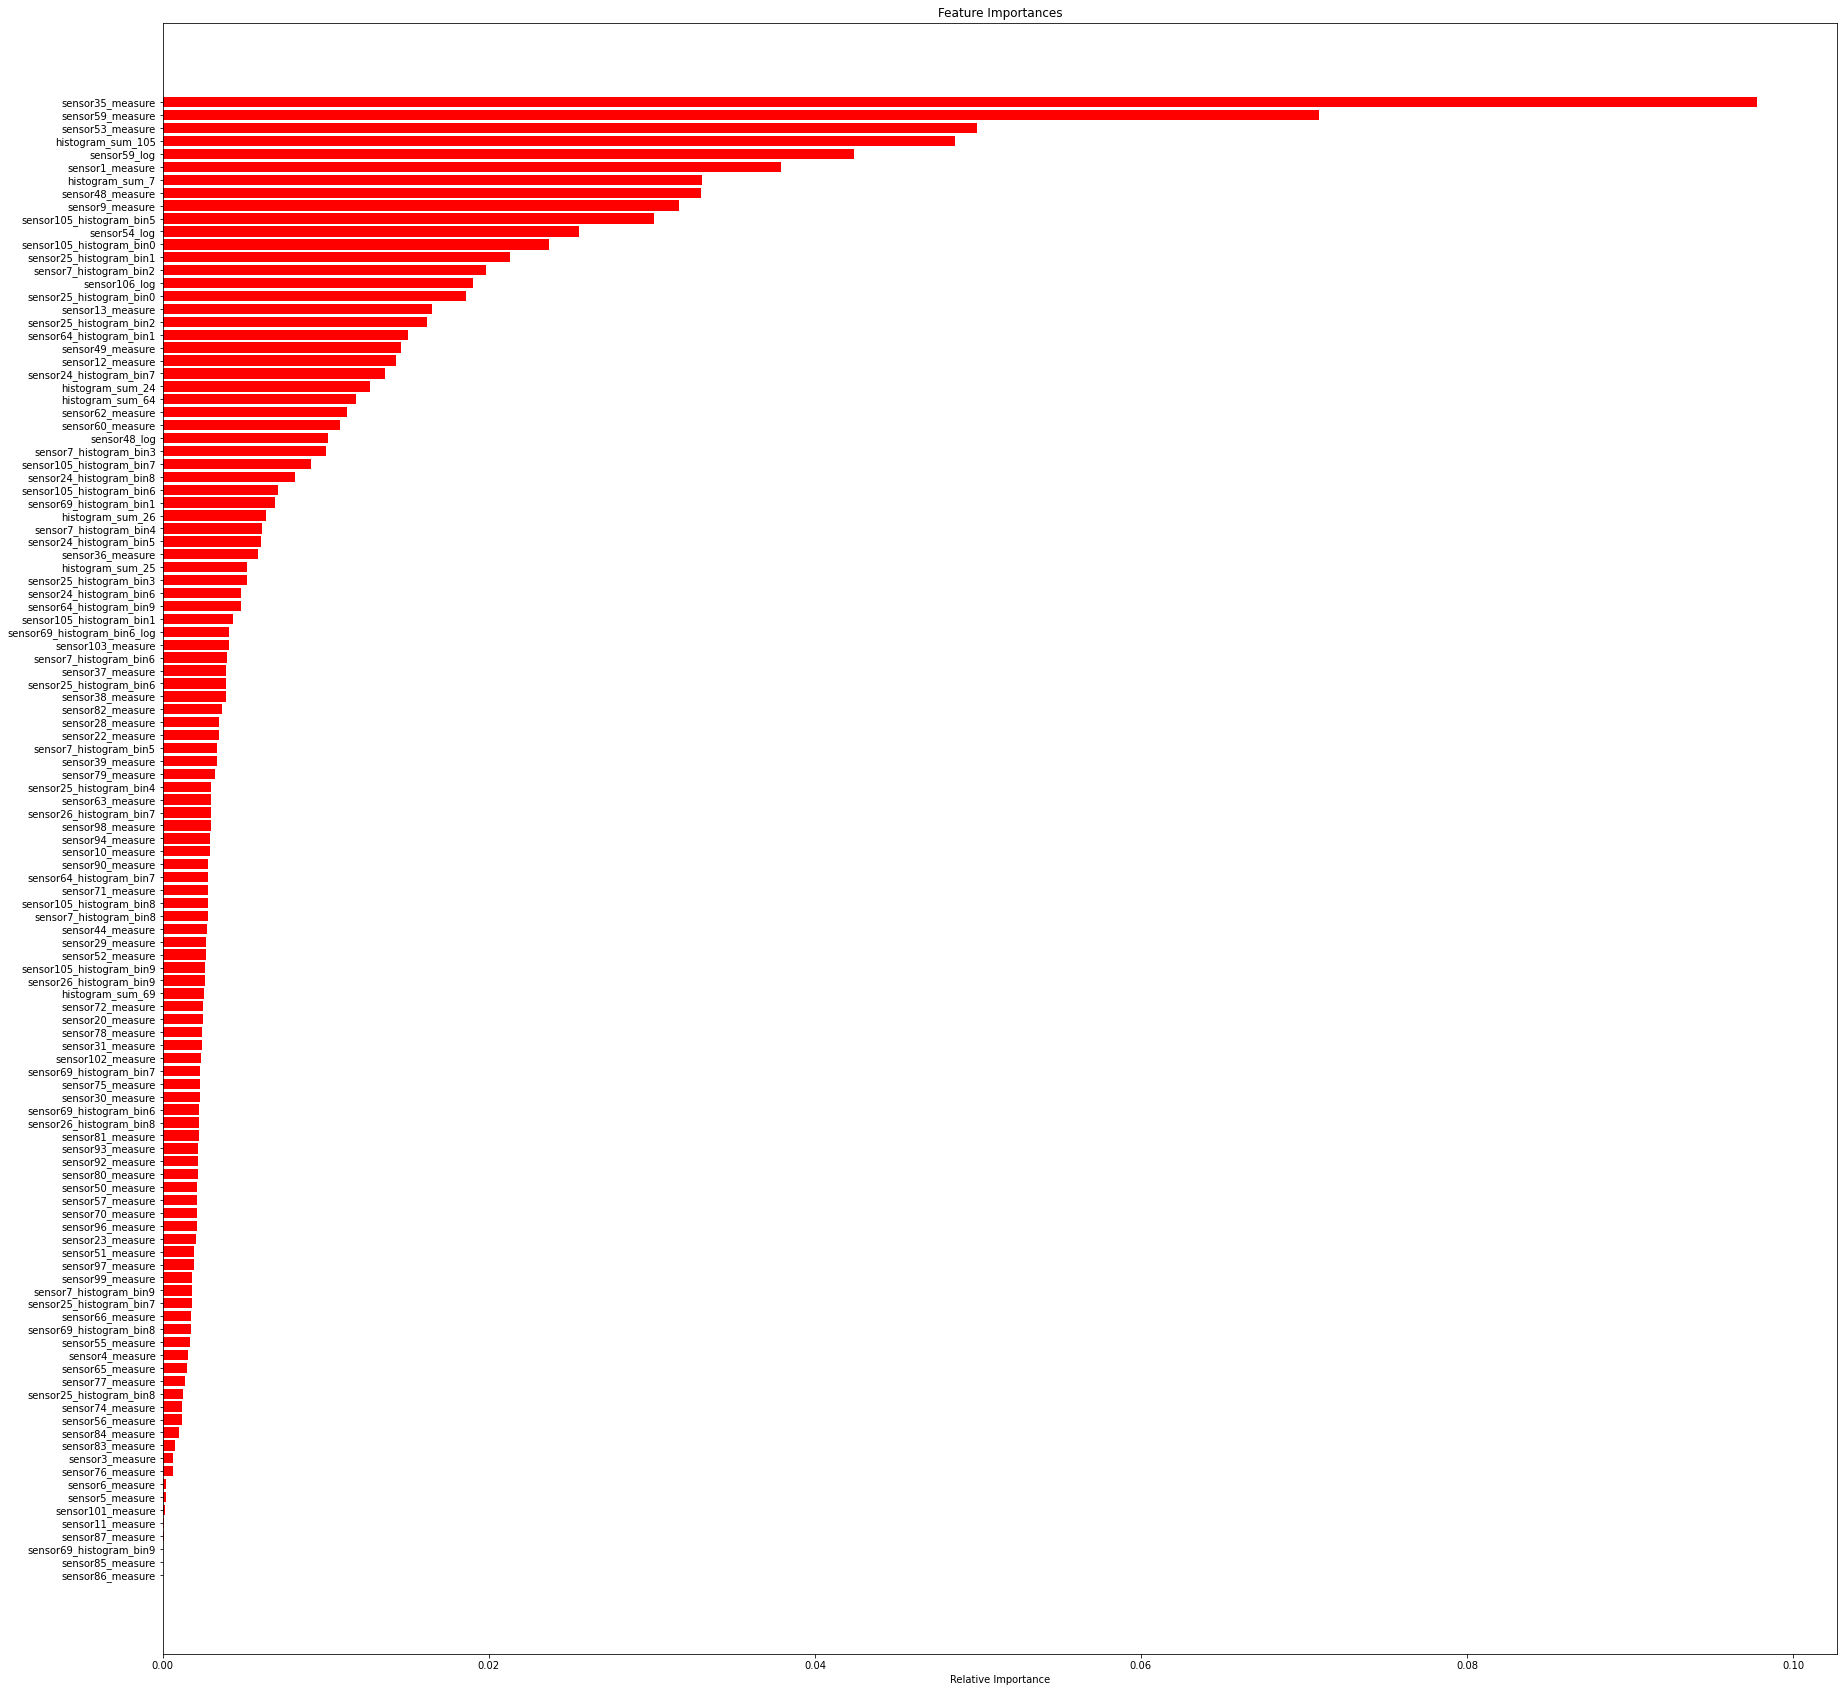

In [202]:
features = X_train.columns
importances = random_forest.feature_importances_   #checking the importance of each feature towards the contribution of builiding this model
indices = (np.argsort(importances))
plt.figure(figsize=(30,30))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [203]:
features = X_train.columns
importances = random_forest.feature_importances_
indices = (np.argsort(importances))[:25]    #Most of the features have a significant importance and hence let us remove the least 25 important features
redundant=[]
for i in indices:
    redundant.append(features[i]) 

#removing the least important features.
X_tr_rf=X_train.drop(redundant,axis=1)
X_cv_rf=X_cv.drop(redundant,axis=1)
X_te_rf=X_test.drop(redundant,axis=1)

### Random Forest with important Features


F1 score for : 10 is 0.7190082644628099 
F1 score for : 50 is 0.761904761904762 
F1 score for : 100 is 0.7673469387755101 
F1 score for : 500 is 0.7773279352226721 
F1 score for : 1000 is 0.7710843373493975 
F1 score for : 2000 is 0.7804878048780488 

  Best alpha (hyperparameter) : 2000 



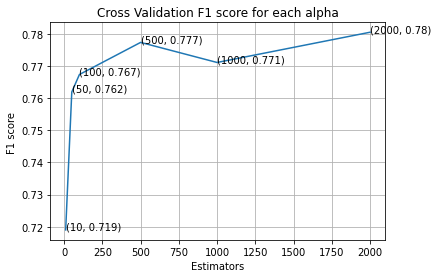


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  1.0
F1_score for cv data :  0.7741935483870969
F1_score for test data :  0.810126582278481
****************************************************************************************************
Confusion Matrix for the Train Data  

Percentage of misclassified points  0.0


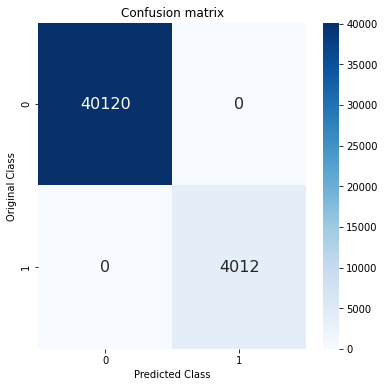

****************************************************************************************************
Confusion Matrix for the Test Data  

Percentage of misclassified points  0.625


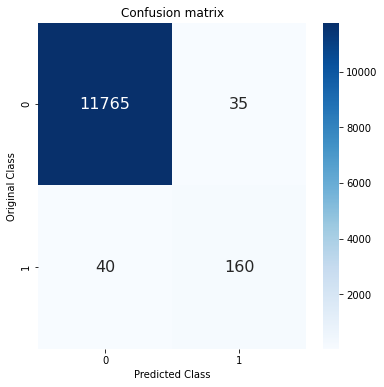

****************************************************************************************************


In [204]:
#choosing the best hyperparameters

alpha=[10,50,100,500,1000,2000]

#storing the f1 score for all hyperparameters in an array
cv_f1score_array=[]
for i in tqdm(alpha):
    random_forest=RandomForestClassifier(n_estimators=i,n_jobs=-1)
    random_forest.fit(X_tr_rf,y_train)
    predict_y = random_forest.predict(X_cv_rf)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))

#displaying the F1 score for all hyperparameters      
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#best hyperparameter
best_alpha = np.argmax(cv_f1score_array)

print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha]  ,'\n')

#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots() 

#plotting hyperparameter V/S F1score  graph
ax.plot(alpha, cv_f1score_array) 
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Estimators")
plt.ylabel("F1 score ")
plt.show()


#fitting the classifier with best hyperparameter
random_forest=RandomForestClassifier(n_estimators=alpha[best_alpha],n_jobs=-1)
random_forest.fit(X_tr_rf, y_train)

#predicting actual labels
pred_y=random_forest.predict(X_te_rf)

#displaying the perfomance metric for train,cv and test data
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = random_forest.predict(X_tr_rf)
print ('F1 score for train data : ',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = random_forest.predict(X_cv_rf)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = random_forest.predict(X_te_rf)
print ('F1_score for test data : ',f1_score(y_test, pred_y_test, average='binary'))
print('*'*100)
print("Confusion Matrix for the Train Data ",'\n')
confusion_mat(y_train,pred_y_train)
print('*'*100)
print("Confusion Matrix for the Test Data ",'\n')
confusion_mat(y_test,pred_y_test)
print('*'*100)

#Xgboost Classifier

In [245]:
weight=Counter(y_train)    #To Compensate for the imbalance in the dataset we use scale_pos_weight it has  the effect of weighing the balance of positive examples, relative to negative examples when boosting decision trees.
weight=weight[0]/weight[1]
print(weight)

10.0


### XGBoost using RandomizedCV hyperparameter tuning

In [238]:
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

x_cfl=XGBClassifier(scale_pos_weight=10)

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,scoring='f1',n_jobs=-1)
random_cfl1.fit(X_train,y_train)
print("The best Hyperparameters are ",'\n')
print(random_cfl1.best_params_)                                           

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 36.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 39.1min finished


{'subsample': 1, 'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.03, 'colsample_bytree': 0.5}



 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data 1.0
F1_score for cv data 0.7929515418502203
F1_score for test data 0.8216216216216216
****************************************************************************************************
Confusion Matrix for the Train Data  

Percentage of misclassified points  0.0


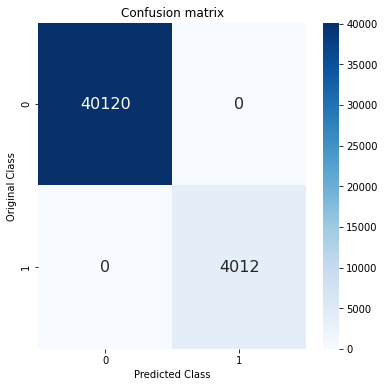

****************************************************************************************************
Confusion Matrix for the Test Data  

Percentage of misclassified points  0.5499999999999999


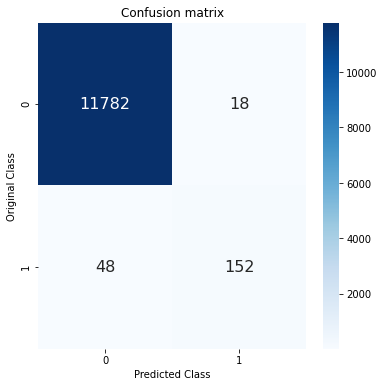

****************************************************************************************************


In [240]:
x_cfl=XGBClassifier(n_estimators=2000,subsample=1,max_depth=5,learning_rate=0.03,colsample_bytree=0.5,scale_pos_weight=10,n_jobs=-1)
x_cfl.fit(X_train, y_train)
c_cfl1 = CalibratedClassifierCV(x_cfl, method="isotonic")
c_cfl1.fit(X_train,y_train)


predict_y_train = c_cfl1.predict(X_train)
print ('train F1_score',f1_score(y_train,predict_y_train,average='binary'))
predict_y = c_cfl1.predict(X_cv)
print ('cv F1_score',f1_score(y_cv, predict_y,average='binary'))
predict_y_test = c_cfl1.predict(X_test)
print ('test F1_Score',f1_score(y_test, predict_y_test,average='binary'))
print('*'*100)
print("Confusion Matrix for the Train Data ",'\n')
confusion_mat(y_train,predict_y_train)
print('*'*100)
print("Confusion Matrix for the Test Data ",'\n')
confusion_mat(y_test,predict_y_test)
print('*'*100)

### XGBoost using cross validation dataset for hyperparameter tuning


F1 score for : 10 is 0.5081967213114754 
F1 score for : 50 is 0.5674157303370787 
F1 score for : 100 is 0.6329113924050633 
F1 score for : 500 is 0.7698412698412699 
F1 score for : 1000 is 0.7868852459016393 

  Best alpha (hyperparameter) : 1000 



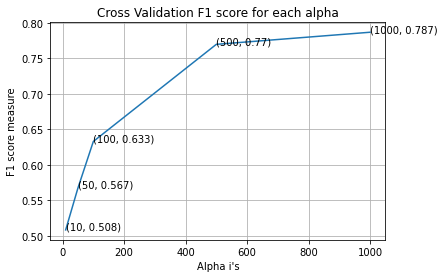


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data 1.0
F1_score for cv data 0.7868852459016393
F1_score for test data 0.8290155440414508


In [205]:
#choosing the best hyperparameters

from collections import Counter
c1=Counter(y_train)
c=c1[0]/c1[1]

alpha=[10,50,100,500,1000]

#storing the f1 score for all hyperparameters in an array
cv_f1score_array=[]
for i in tqdm(alpha):
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1,scale_pos_weight=c)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict(X_cv)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))

#displaying the F1 score for all hyperparameters      
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#best hyperparameter
best_alpha_XGB = np.argmax(cv_f1score_array)

print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha_XGB]  ,'\n')
#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots()

#plotting hyperparameter V/S F1score  
ax.plot(alpha, cv_f1score_array)
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("F1 score measure")
plt.show()

#fitting the classifier with best hyperparameter
x_cfl=XGBClassifier(n_estimators=alpha[best_alpha_XGB],nthread=-1,scale_pos_weight=c)
x_cfl.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

#predicting actual labels
pred_y=sig_clf.predict(X_test)

#displaying the perfomance metric for train,cv and test data

print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train =sig_clf.predict(X_train)
print ('F1 score for train data',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = sig_clf.predict(X_cv)
print ('F1_score for cv data',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = sig_clf.predict(X_test)
print ('F1_score for test data',f1_score(y_test, pred_y_test, average='binary'))



****************************************************************************************************
Confusion Matrix for the Train Data  

Percentage of misclassified points  0.0


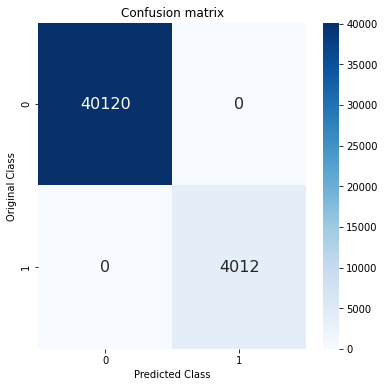

****************************************************************************************************
Confusion Matrix for the Test Data  

Percentage of misclassified points  0.5499999999999999


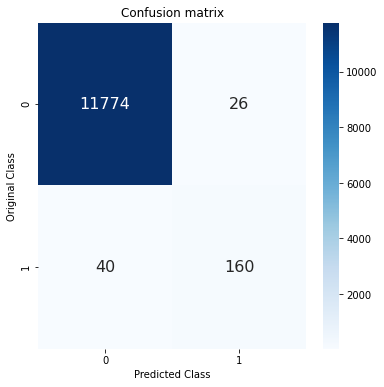

****************************************************************************************************


In [209]:
predict_y_train = sig_clf.predict(X_train)
predict_y = sig_clf.predict(X_cv)

predict_y_test = sig_clf.predict(X_test)

print('*'*100)
print("Confusion Matrix for the Train Data ",'\n')
confusion_mat(y_train,predict_y_train)
print('*'*100)
print("Confusion Matrix for the Test Data ",'\n')
confusion_mat(y_test,predict_y_test)
print('*'*100)

### XGBoost on important features

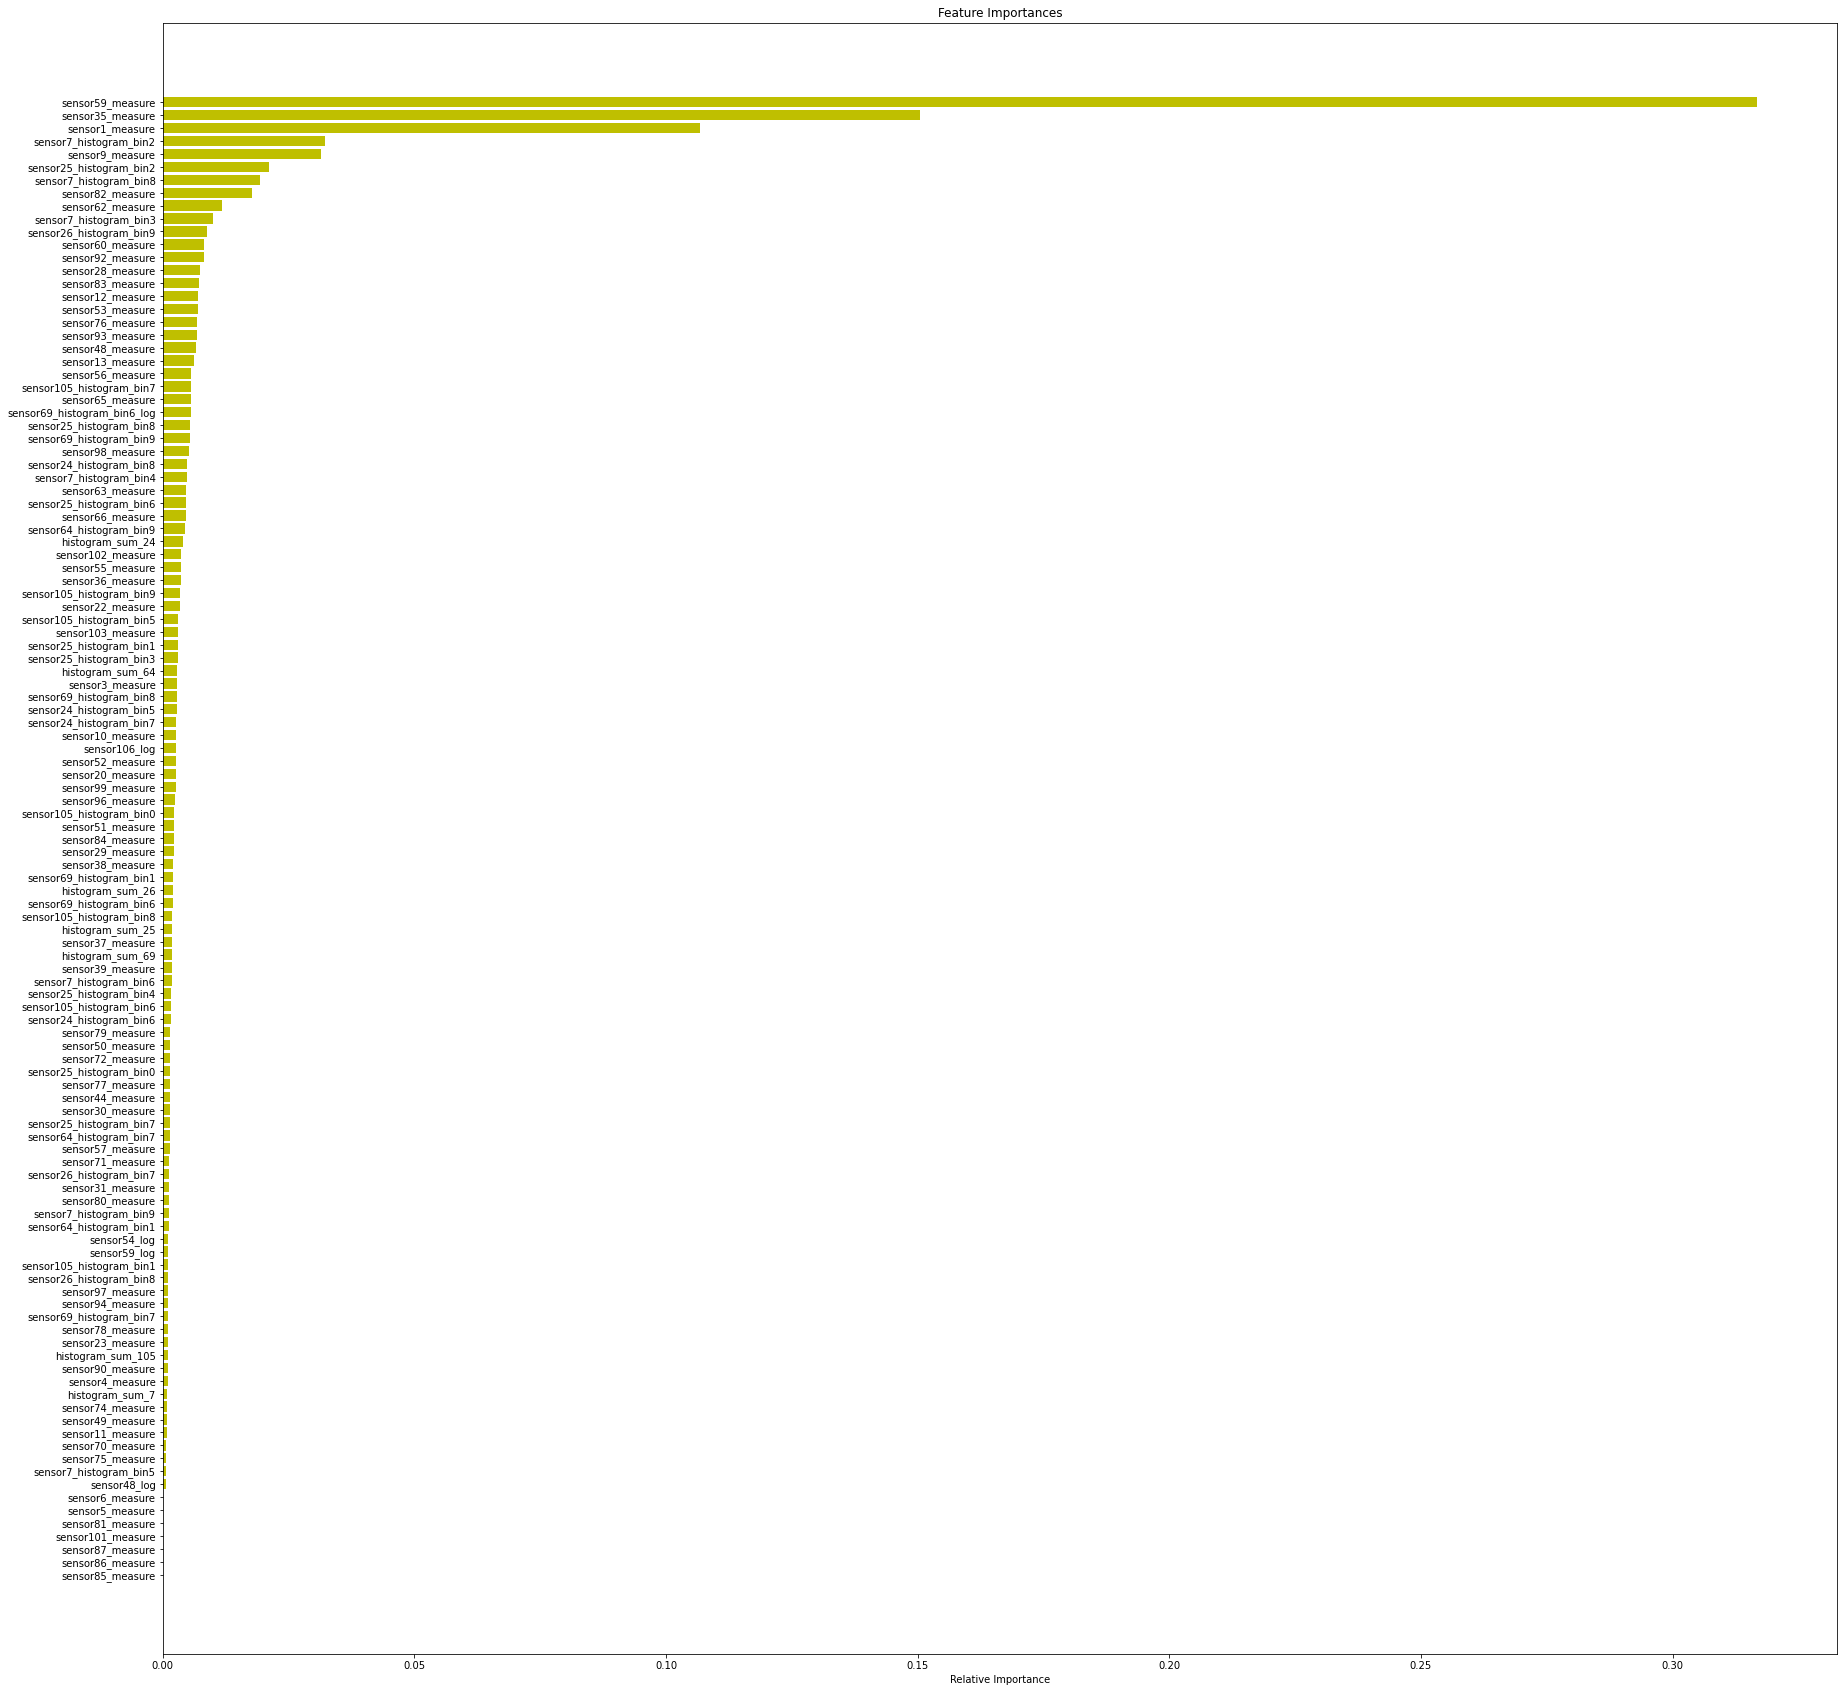

In [207]:
#feature importance for XGBOOST
features = X_train.columns
importances = x_cfl.feature_importances_     
indices = (np.argsort(importances))
plt.figure(figsize=(30,30))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='y', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [208]:
features = X_train.columns
importances = x_cfl.feature_importances_
indices = (np.argsort(importances))[:45]            #There are many features with insignificant importance. We shall be dropping the least 45 important features
redundant=[]
for i in indices:
    redundant.append(features[i])  

#removing the least important features.
X_train_XGB=X_train.drop(rem_feat,axis=1)
X_cv_XGB=X_cv.drop(rem_feat,axis=1)
X_test_XGB=X_test.drop(rem_feat,axis=1)


F1 score for : 10 is 0.5068119891008174 
F1 score for : 50 is 0.5617977528089888 
F1 score for : 100 is 0.6496815286624205 
F1 score for : 500 is 0.7826086956521738 
F1 score for : 1000 is 0.8083333333333333 

  Best alpha (hyperparameter) : 1000 



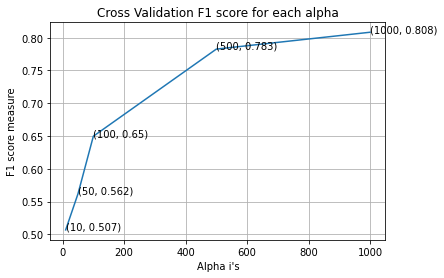


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data 1.0
****************************************************************************************************
Confusion Matrix for the Train Data  

Percentage of misclassified points  0.0


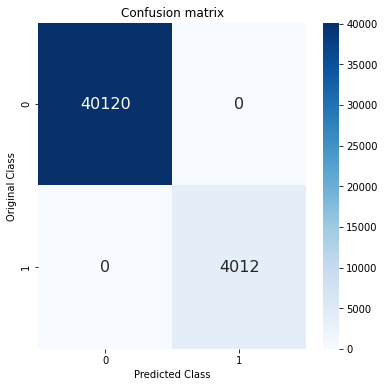

F1_score for cv data 0.8083333333333333
F1_score for test data 0.8103896103896104
****************************************************************************************************
Confusion Matrix for the Train Data  

Percentage of misclassified points  0.6083333333333333


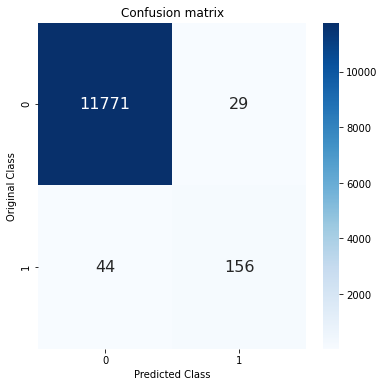

In [210]:
#choosing the best hyperparameters


alpha=[10,50,100,500,1000]

#storing the f1 score for all hyperparameters in an array
cv_f1score_array=[]
for i in tqdm(alpha):
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1,scale_pos_weight=c)
    x_cfl.fit(X_train_XGB,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_XGB, y_train)
    predict_y = sig_clf.predict(X_cv_XGB)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))

#displaying the F1 score for all hyperparameters      
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#best hyperparameter
best_alpha_XGB = np.argmax(cv_f1score_array)

print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha_XGB]  ,'\n')
#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots()

#plotting hyperparameter V/S F1score  
ax.plot(alpha, cv_f1score_array)
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("F1 score measure")
plt.show()

#fitting the classifier with best hyperparameter
x_cfl=XGBClassifier(n_estimators=alpha[best_alpha_XGB],nthread=-1,scale_pos_weight=c)
x_cfl.fit(X_train_XGB, y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_XGB, y_train)

#predicting actual labels
pred_y=sig_clf.predict(X_test_XGB)

#displaying the perfomance metric for train,cv and test data

print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train =sig_clf.predict(X_train_XGB)
print ('F1 score for train data',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = sig_clf.predict(X_cv_XGB)
print('*'*100)
print("Confusion Matrix for the Train Data ",'\n')
confusion_mat(y_train,pred_y_train)
print ('F1_score for cv data',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = sig_clf.predict(X_test_XGB)
print ('F1_score for test data',f1_score(y_test, pred_y_test, average='binary'))
print('*'*100)
print("Confusion Matrix for the Train Data ",'\n')
confusion_mat(y_test,pred_y_test)

### Voting Classifier


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  0.9843037974683544
F1_score for cv data :  0.7530364372469637
F1_score for test data :  0.8050632911392405
****************************************************************************************************
Confusion Matrix for the Train Data  

Percentage of misclassified points  0.2809752560500317


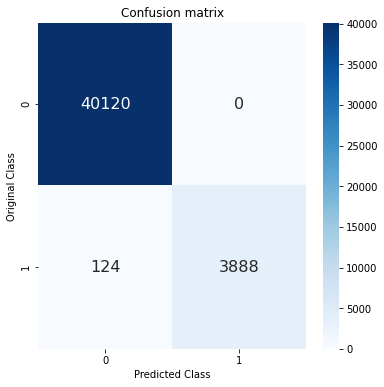

****************************************************************************************************
Confusion Matrix for the Test Data  

Percentage of misclassified points  0.6416666666666667


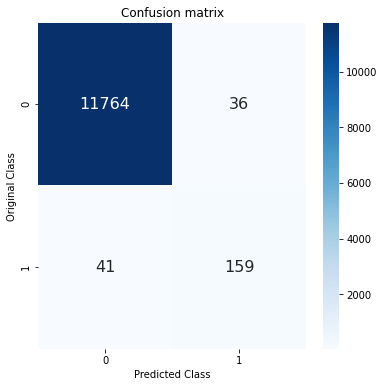

****************************************************************************************************


In [224]:
from sklearn.ensemble import VotingClassifier
v_clf = VotingClassifier(
    estimators=[('lr', logistic), ('rf', random_forest), ('KNN', KNN),('xbgoost',x_cfl)],
    voting='hard',n_jobs=-1)

v_clf.fit(X_train, y_train)

#predicting actual labels
pred_y=v_clf.predict(X_test)

#displaying the perfomance metric for train,cv and test data
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = v_clf.predict(X_train)
print ('F1 score for train data : ',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = v_clf.predict(X_cv)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = v_clf.predict(X_test)
print ('F1_score for test data : ',f1_score(y_test, pred_y_test, average='binary'))
pred_y=sig_clf.predict(X_test)


print('*'*100)
print("Confusion Matrix for the Train Data ",'\n')
confusion_mat(y_train,pred_y_train)
print('*'*100)
print("Confusion Matrix for the Test Data ",'\n')
confusion_mat(y_test,pred_y_test)
print('*'*100)

#displaying the perfomance metric for train,cv and test data





*   Considering the improvement in the model it isn't worth building because of the time it takes to train and test . Which would be considered as an overkill for the meagre improvement in the performance.

*   The models pickle size is above 300mb which is greater than other models.





### XGBoost with important features using Randomized CV hyperparameter tuning

In [233]:
x_cfl_h=XGBClassifier(scale_pos_weight=10)

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl_h,param_distributions=prams,n_jobs=-1,scoring='f1',verbose=10)
random_cfl1.fit(X_train_XGB,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 31.7min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [234]:
print (random_cfl1.best_params_)                                               

{'subsample': 0.5, 'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1}



 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data 1.0
F1_score for cv data 0.8141592920353983
F1_score for test data 0.8254847645429363
****************************************************************************************************
Confusion Matrix for the Train Data  

Percentage of misclassified points  0.0


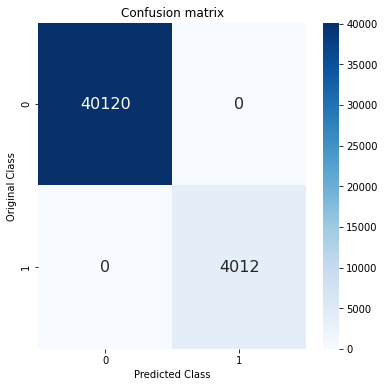

****************************************************************************************************
Confusion Matrix for the Test Data  

Percentage of misclassified points  0.525


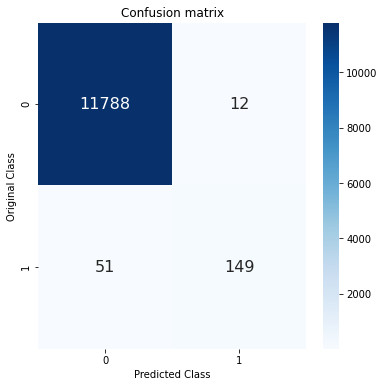

****************************************************************************************************


In [235]:
x_cfl_h=XGBClassifier(n_estimators=2000,subsample=0.5,max_depth=5,learning_rate=0.05,colsample_bytree=1,scale_pos_weight=10)
x_cfl_h.fit(X_train_XGB, y_train)
sig_clf_h = CalibratedClassifierCV(x_cfl_h, method="isotonic")
sig_clf_h.fit(X_train_XGB, y_train)

#displaying the perfomance metric for train,cv and test data
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train =sig_clf_h.predict(X_train_XGB)
print ('F1 score for train data',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = sig_clf_h.predict(X_cv_XGB)
print ('F1_score for cv data',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = sig_clf_h.predict(X_test_XGB)
print ('F1_score for test data',f1_score(y_test, pred_y_test, average='binary'))
print('*'*100)
print("Confusion Matrix for the Train Data ",'\n')
confusion_mat(y_train,pred_y_train)
print('*'*100)
print("Confusion Matrix for the Test Data ",'\n')
confusion_mat(y_test,pred_y_test)
print('*'*100)

#Summary

In [108]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Model","Hyperparameter","Hyperparameter value","Train F1 score","Test F1 Score",'Test Misclassification rate']
x.add_row([ "KNN", 'alpha',13,'0.916','0.645','1.554'])
x.add_row([ "Logistic Regression", 'C',100 ,'0.871','0.748','2.238'])
x.add_row([ "SVM", 'alpha', 0.001,'0.803','0.445','3.916'])
x.add_row([ "Random Forest", 'n_estimators',100, '1','0.811','0.616'])
x.add_row([ "Random Forest using important features", 'n_estimators',2000, '1.0','0.810','0.625'])
x.add_row(["XGboost using RandomizedCV",'[learning_rate,n_estimators,max_depth,colsample_bytree,subsample]','[1,2000,5,0.03,0.5]','1.0','0.821','0.5499'])
x.add_row(["XGBoost for important features",'n_estimators','1000','1.0','0.829','0.549'])
x.add_row(["XGBoost using cross validation dataset for hyperparameter tuning",'n_estimators','1000','1.0','0.810','0.608'])
x.add_row(["XGBoost with important features using Randomized CV hyperparameter tuning",'[learning_rate,n_estimators,max_depth,colsample_bytree,subsample]','[0.5,2000,5,0.05,1]','1.0','0.825','0.525'])
x.add_row([ "Voting Classifier", 'Models','[Logistic Rgression,KNN,Random Forest,Xgboost]', '0.984','0.805','0.641'])


print(x)

+---------------------------------------------------------------------------+-------------------------------------------------------------------+------------------------------------------------+----------------+---------------+-----------------------------+
|                                   Model                                   |                           Hyperparameter                          |              Hyperparameter value              | Train F1 score | Test F1 Score | Test Misclassification rate |
+---------------------------------------------------------------------------+-------------------------------------------------------------------+------------------------------------------------+----------------+---------------+-----------------------------+
|                                    KNN                                    |                               alpha                               |                       13                       |     0.916      |     0.645     



* Best Model obtained is using XGBoost using cross validation dataset for hyperparameter tuning with a test F1 score of 0.829 

